### Experiments for Reconstruction of networks using scoring with LSM or with random additions.

In [ ]:
# Ensure necessary packages are installed
!pip install cobra efmtool numpy pandas scipy

Definition of the EV Network from Eberhard Voit's "A first course in Systems Biology"

In [1]:
from cobra import Model, Reaction, Metabolite

# Modell erstellen
model = Model("Toy_Network")

# Metaboliten definieren (intern)
A = Metabolite("A", compartment="c")
B = Metabolite("B", compartment="c")
C = Metabolite("C", compartment="c")
D = Metabolite("D", compartment="c")
E = Metabolite("E", compartment="c")

# Metaboliten definieren (extern)
A_e = Metabolite("A_e", compartment="e")
B_e = Metabolite("B_e", compartment="e")
D_e = Metabolite("D_e", compartment="e")
E_e = Metabolite("E_e", compartment="e")

# Reaktionen definieren
r1_in = Reaction("r1_in")
r1_in.name = "A import"
r1_in.lower_bound = 0
r1_in.upper_bound = 1000
r1_in.add_metabolites({A_e: -1, A: 1})

r2 = Reaction("r2")
r2.name = "A to C"
r2.lower_bound = 0
r2.upper_bound = 1000
r2.add_metabolites({A: -1, C: 1})

r3 = Reaction("r3")
r3.name = "C to D and E"
r3.lower_bound = 0
r3.upper_bound = 1000
r3.add_metabolites({C: -1, D: 1, E: 1})

r4_out = Reaction("r4_out")
r4_out.name = "D export"
r4_out.lower_bound = 0
r4_out.upper_bound = 1000
r4_out.add_metabolites({D: -1, D_e: 1})

r5 = Reaction("r5")
r5.name = "A to B"
r5.lower_bound = 0
r5.upper_bound = 1000
r5.add_metabolites({A: -1, B: 1})

r6r = Reaction("r6r")
r6r.name = "B to C"
r6r.lower_bound = -1000
r6r.upper_bound = 1000
r6r.add_metabolites({B: -1, C: 1})

r7 = Reaction("r7")
r7.name = "B to D"
r7.lower_bound = 0
r7.upper_bound = 1000
r7.add_metabolites({B: -1, D: 1})

r8r_out = Reaction("r8r_out")
r8r_out.name = "B import"
r8r_out.lower_bound = -1000
r8r_out.upper_bound = 1000
r8r_out.add_metabolites({B_e: -1, B: 1})

r9_out = Reaction("r9_out")
r9_out.name = "E export"
r9_out.lower_bound = 0
r9_out.upper_bound = 1000
r9_out.add_metabolites({E: -1, E_e: 1})

# Reaktionen zum Modell hinzufügen
model.add_reactions([r1_in, r2, r3, r4_out, r5, r6r, r7, r8r_out, r9_out])

# Modell überprüfen
print("Reaktionen:", [rxn.id for rxn in model.reactions])
print("Metaboliten:", [met.id for met in model.metabolites])
print("Gene:", [gene.id for gene in model.genes])




Reaktionen: ['r1_in', 'r2', 'r3', 'r4_out', 'r5', 'r6r', 'r7', 'r8r_out', 'r9_out']
Metaboliten: ['A_e', 'A', 'C', 'D', 'E', 'D_e', 'B', 'B_e', 'E_e']
Gene: []


Method to retrieve the stochiometric matrix of a COBRApy model.

In [2]:
import numpy as np
import cobra


def get_stoichiometric_matrix(model):
    # Filtere die Reaktionen, um nur Reaktionen zu behalten, die nicht mit "EX_" beginnen
    internal_reactions = [rxn for rxn in model.reactions if not rxn.id.startswith("EX_")]

    # Extrahiere die Metaboliten aus dem Modell
    internal_metabolites = [meta for meta in model.metabolites if not meta.compartment == 'e']

    # Erstelle die leere Stöchiometrie-Matrix mit (Anzahl der Metaboliten, Anzahl der internen Reaktionen)
    stoichiometric_matrix = np.zeros((len(internal_metabolites), len(internal_reactions)))

    # Befülle die Stöchiometrie-Matrix so, dass jede Spalte eine Reaktion repräsentiert
    for j, rxn in enumerate(internal_reactions):  # Spaltenweise über Reaktionen iterieren
        for i, met in enumerate(internal_metabolites):  # Zeilenweise über Metaboliten iterieren
            stoichiometric_matrix[i, j] = rxn.metabolites.get(met, 0)  # Falls Metabolit nicht in der Reaktion ist, wird 0 zurückgegeben
    return stoichiometric_matrix


In [3]:
stoichiometry=get_stoichiometric_matrix(model)
print("Stoichiometric matrix shape:", stoichiometry.shape)
print("Stoichiometric matrix:", stoichiometry)


Stoichiometric matrix shape: (5, 9)
Stoichiometric matrix: [[ 1. -1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1. -1.  1.  0.]]


Method to calculate the Elementary Flux Modes for a COBRApy model

In [4]:
import efmtool
import cobra
import numpy as np
from efmtool import calculate_efms

def cobra_to_efms(model):
    # 1. Stoichiometric matrix (S matrix)
    metabolites = [
    metabolite for metabolite in model.metabolites 
    if metabolite.compartment == "c"
    ]
    reactions = model.reactions
    stoichiometry = np.zeros((len(metabolites), len(reactions)))
    #stoichiometry = get_stoichiometric_matrix(model)
    
    for i, met in enumerate(metabolites):
        for j, rxn in enumerate(reactions):
            try:
                stoichiometry[i, j] = rxn.get_coefficient(met.id)
            except KeyError:
                
                stoichiometry[i, j] = 0.0
    
    print("Stoichiometric matrix shape:", stoichiometry.shape)
    print("Stoichiometric matrix:", stoichiometry)

    # 2. Reversibilities: 1 for reversible, 0 for irreversible reactions
    reversibilities = [1 if rxn.reversibility else 0 for rxn in reactions]
    
    print("Reversibilities:", reversibilities)
    print("Number of reactions:", len(reactions))

    # 3. Reaction names
    reaction_names = [rxn.id for rxn in reactions]
    
    # 4. Metabolite names
    metabolite_names = [met.id for met in metabolites]
    
    return calculate_efms(stoichiometry, reversibilities, reaction_names, metabolite_names), reaction_names





# 6. Berechne die Elementarmoden (EFMs) mit dem efmtool und Reaktionsnamen
efms, reaction_names = cobra_to_efms(model)

# 7. Ergebnisse anzeigen
print("Berechnete Elementarmoden:")
print(np.column_stack((reaction_names, efms)))


Stoichiometric matrix shape: (5, 9)
Stoichiometric matrix: [[ 1. -1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1. -1.  1.  0.]]
Reversibilities: [0, 0, 0, 0, 0, 1, 0, 1, 0]
Number of reactions: 9
2024-12-31  13:40:09.853  main                     INFO     | logger initialized
2024-12-31  13:40:09.854  main                     INFO     | =====================================================
2024-12-31  13:40:09.854  main                     INFO     | efmtool version 4.7.1, 2009-12-04 18:30:05
2024-12-31  13:40:09.854  main                     INFO     | Copyright (c) 2009, Marco Terzer, Zurich, Switzerland
2024-12-31  13:40:09.854  main                     INFO     | This is free software, !!! NO WARRANTY !!!
2024-12-31  13:40:09.854  main                     INFO     | See LICENCE.txt for redistribution conditions
2024-12-31  13:40:09.854  main                

Definition of the Datapoints from Elementary Flux Modes

In [109]:
import numpy as np


input_array = np.column_stack((reaction_names, efms))

# Extract headers and values
headers = input_array[:, 0]
values = input_array[:, 1:].astype(float)  # Convert values to float

# Construct dictionaries
experimental_data = []
for col_idx in range(values.shape[1]):
    data_point = {}
    for row_idx, header in enumerate(headers):
        if header.endswith("_in") or header.endswith("_out"):
            # Add only reactions ending with "_in" or "_out"
            data_point[header] = values[row_idx, col_idx]
    # Normalize so "A_in" is always 1.0
    if "r1_in" in data_point and data_point["r1_in"] != 0.0:
        normalization_factor = data_point["r1_in"]
        for key in data_point.keys():
            data_point[key] /= normalization_factor
    else:
        if ("r8r_out" in data_point and data_point["r8r_out"] > 0):
            normalization_factor = data_point["r8r_out"]
            for key in data_point.keys():
                data_point[key] /= normalization_factor
        
    experimental_data.append(data_point)

# Output the result
for data in experimental_data:
    print(data)

experimental_data_zeropadded_out = experimental_data

{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}
{'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}
{'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}
{'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}
{'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}


In [7]:
S = get_stoichiometric_matrix(model)
print(S)

[[ 1. -1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1. -1.  1.  0.]]


In [8]:
S

array([[ 1., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.]])

Method to calculate the Fit-Score of a model for some experimental data

In [82]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import minimize





#print(reaction_ids)
# Funktion zur Ableitung des Zielvektors aus den experimentellen Daten
def create_target_vector(data_point, reaction_ids):
    target_flux = np.full(len(reaction_ids), np.nan)  # Vektor mit NaN initialisieren
    for rxn_id, value in data_point.items():
        if rxn_id in reaction_ids:  # Nur Reaktionen, die im Modell existieren
            idx = reaction_ids.index(rxn_id)
            target_flux[idx] = value  # Setze den Zielwert
    return target_flux


def least_square_min(model, S, experimental_data):
    reaction_ids = [rxn.id for rxn in model.reactions if not rxn.id.startswith("EX_")]
    total_score = 0.0
    successful_optimizations = 0

    for data_point in experimental_data:
        # Zielvektor für aktuellen Datenpunkt erstellen
        target_flux = create_target_vector(data_point, reaction_ids)

        # Filter für bekannte Flüsse (Reaktionen, die in 'target_flux' nicht NaN sind)
        known_flux_indices = ~np.isnan(target_flux)
        target_flux_values = target_flux[known_flux_indices]

        def objective(x):
            return np.linalg.norm(x[known_flux_indices] - target_flux_values)

        constraints = {'type': 'eq', 'fun': lambda x: np.dot(S, x)}

        initial_guess = np.zeros(len(reaction_ids))
        bounds = [(model.reactions.get_by_id(rxn_id).lower_bound,
                   model.reactions.get_by_id(rxn_id).upper_bound)
                  for rxn_id in reaction_ids]

        result = minimize(objective, initial_guess, constraints=constraints, bounds=bounds, tol=1e-10)

        if result.success:
            optimized_flux = result.x
            total_score += np.linalg.norm(optimized_flux[known_flux_indices] - target_flux_values)
            successful_optimizations += 1
        else:
            print(f"Optimization failed for data point: {data_point}. Message: {result.message}")

    # Return None if any optimization failed, otherwise the total score
    if successful_optimizations < len(experimental_data):
        return 0.0, len(experimental_data)
    else:
        return total_score, len(experimental_data)

 
S = get_stoichiometric_matrix(model)
print(least_square_min(model, S, experimental_data_zeropadded_out))

(3.123498217099662e-08, 8)


Method to generate random reactions for metabolites from the model.

In [94]:
import random
from cobra import Reaction

# Erstellen von Reaktionen mit 1-2 Substrat(en) und 1-2 Produkt(en)
def generate_random_reactions(model, num_reactions=2000):
    # Filter out metabolites that end with '_EX'
    metabolites = [met for met in model.metabolites if not met.compartment == 'e']
    random_reactions = []

    for i in range(num_reactions):
        reaction_valid = False

        while not reaction_valid:
            # Zufällige Auswahl der Anzahl an Substraten und Produkten
            num_reactants = random.randint(1, 2)
            num_products = random.randint(1, 2)

            # Zufällige Auswahl der Substrate und Produkte
            reactants = random.sample(metabolites, num_reactants)
            products = random.sample(metabolites, num_products)

            # Check, dass auf beiden Seiten Metaboliten vorhanden sind
            if set(reactants).isdisjoint(set(products)):
                reaction_valid = True

                # Erstellung der Reaktion
                reaction = Reaction(f'Random_Rxn_{i+1}')
                reaction.name = f'Random Reaction {i+1}'

                reaction.add_metabolites({
                    met: -1.0 for met in reactants
                })
                reaction.add_metabolites({
                    met: 1.0 for met in products
                })

                # 50% Chance, die Reaktion reversibel zu machen
                if random.random() < 0.5:
                    reaction.lower_bound = -1000.0
                else:
                    reaction.lower_bound = 0.0

                reaction.upper_bound = 1000.0

                random_reactions.append(reaction)

    return random_reactions

# Generierung von 2000 zufälligen Reaktionen + den Inversen
random_reactions_list = generate_random_reactions(model, num_reactions=2000)

# Anzahl der insgesamt generierten Reaktionen
print(f"\nTotal number of random reactions generated: {len(random_reactions_list)}")


Total number of random reactions generated: 2000


Methods to sample reactions (either from a model or from a list):

In [11]:
import cobra
import random

def sample_reactions(model, n_reactions):
    
    # Filter reactions that do not end with '_in' or '_out'
    valid_reactions = [rxn for rxn in model.reactions if not rxn.id.endswith('_in') and not rxn.id.endswith('_out')]

    # Ensure that the model has enough valid reactions
    if n_reactions > len(valid_reactions):
        raise ValueError("Requested number of reactions exceeds the total number of valid reactions in the model")

    # Sample reactions randomly from the valid reactions list
    sampled_reactions = random.sample(valid_reactions, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id)
    
    return sampled_reactions


In [12]:
import random

def sample_reactions_from_list(reactions_list, n_reactions):
    
    # Ensure the list has enough reactions to sample from
    if n_reactions > len(reactions_list):
        raise ValueError("Requested number of reactions exceeds the total number of reactions in the list")

    # Sample reactions randomly from the given list
    sampled_reactions = random.sample(reactions_list, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id if hasattr(rxn, 'id') else rxn)  # Print the ID if the object has one

    return sampled_reactions


Method to calculate the Model-Score between two models.

In [13]:
def model_edit_distance(model1, model2):
    
    # Get sets of reaction IDs for both models
    reactions_model1 = {rxn.id for rxn in model1.reactions}
    reactions_model2 = {rxn.id for rxn in model2.reactions}
    
    # Calculate the symmetric difference (reactions present in one model but not the other)
    differing_reactions = reactions_model1.symmetric_difference(reactions_model2)
    
    # The edit distance is the number of differing reactions
    edit_distance = len(differing_reactions)
    
    return edit_distance



In [15]:
import pandas as pd

def filter_and_display(list1, list2, list3):
    
    # Erstellen des DataFrames
    df = pd.DataFrame({'Scores': list1, 'Edit Distances': list2, 'Computation Count': list3})
    
    # Filtern: Entfernen von Zeilen mit NaN oder 0.0 in der ersten Liste
    filtered_df = df.dropna(subset=['Scores'])
    filtered_df = filtered_df[filtered_df['Scores'] != 0.0]
    
    # Ergebnis zurückgeben oder anzeigen
    return filtered_df




In [16]:
import cobra

def find_no_production_roots(model):
    
    # Lists for results
    upstream_no_consumption_roots = []
    downstream_no_production_roots = []

    # Initialize dictionaries for production and consumption of metabolites
    metabolite_produced = {met: False for met in model.metabolites if met.compartment == 'c'}
    metabolite_consumed = {met: False for met in model.metabolites if met.compartment == 'c'}

    # Iterate over all reactions in the model
    for reaction in model.reactions:
        if reaction.reversibility:
            # If reversible, treat all metabolites as both reactants and products
            for met in reaction.metabolites:
                metabolite_produced[met] = True
                metabolite_consumed[met] = True
        else:
            # Metabolites produced in this reaction
            for product in reaction.products:
                if product.compartment == 'c':  # Only consider intracellular metabolites
                    metabolite_produced[product] = True

            # Metabolites consumed in this reaction
            for reactant in reaction.reactants:
                if reactant.compartment == 'c':  # Only consider intracellular metabolites
                    metabolite_consumed[reactant] = True

    # Determine Upstream No-Consumption Roots (produced but not consumed)
    for met, produced in metabolite_produced.items():
        if produced and not metabolite_consumed[met]:
            upstream_no_consumption_roots.append(met.id)

    # Determine Downstream No-Production Roots (consumed but not produced)
    for met, consumed in metabolite_consumed.items():
        if consumed and not metabolite_produced[met]:
            downstream_no_production_roots.append(met.id)

    print("Upstream No-Consumption Roots:", upstream_no_consumption_roots)
    print("Downstream No-Production Roots:", downstream_no_production_roots)

    return len(upstream_no_consumption_roots) + len(downstream_no_production_roots)

num_roots = find_no_production_roots(model)
print("Total no-production roots:", num_roots)


Upstream No-Consumption Roots: []
Downstream No-Production Roots: []
Total no-production roots: 0


Method to search reaction with best score after addition to a model.

In [81]:
def score_reaction_lsm(model, reaction, experimental_data):
    # Kopiere das Modell und füge die Reaktion hinzu
    with model:
        model.add_reactions([reaction])
        S = get_stoichiometric_matrix(model)
        score, _ = least_square_min(model, S, experimental_data)
    return score

def add_best_reaction_lsm_chance_random(original_model, experimental_data, random_reactions_list, max_iterations=1):
    # Kopiere das Modell
    model = original_model.copy()

    ccs = 0

    S = get_stoichiometric_matrix(model)
    ini_score, cc = least_square_min(model, S, experimental_data)
    ccs += cc
    print(f"Score before addition: {ini_score}")
    if ini_score == 0.0:
        print(f"Model not solvable: {ini_score}")
        return ini_score, original_model, ccs

    iteration = 0
    while ini_score > 0 and iteration < max_iterations:
        if not random_reactions_list:
            print("No more random reactions to add.")
            break

        # Scoring der Reaktionen
        reaction_scores = {
            reaction.id: score
            for reaction in random_reactions_list
            if (score := score_reaction_lsm(model, reaction, experimental_data)) < ini_score and score > 0.0
        }
        ccs += len(experimental_data) * len(random_reactions_list)

        # Auswahl der besten Reaktion basierend auf dem Score
        if reaction_scores:
            best_reaction_id = min(reaction_scores, key=reaction_scores.get)

            best_reaction = next(r for r in random_reactions_list if r.id == best_reaction_id)
            ini_score = reaction_scores[best_reaction_id]

            print(f"Adding reaction: {best_reaction.id} with score: {reaction_scores[best_reaction_id]}")
            model.add_reactions([best_reaction])
            random_reactions_list.remove(best_reaction)
        else:
            print("No reactions with improvements found")
            break

        iteration += 1

    return ini_score, model, ccs

Reconstruction algorithm:

In [49]:
import time
import numpy as np
import random

def evaluate_score_random_evolution(test_model, experimental_data, sampling_size, num_iterations, chance_random):
    min_value = 0.0
    max_value = 1.0

    # Validate the `chance_random` parameter
    if not (min_value <= chance_random <= max_value):
        raise ValueError(f"Argument 'chance_random' must be between {min_value} and {max_value}. Given: {chance_random}")
    
    scores = np.zeros(num_iterations)
    edit_distances = np.zeros(num_iterations)
    counts_computations = np.zeros(num_iterations)
    score_evolutions = []  # To store the evolution of scores for each iteration
    
    for i in range(num_iterations):
        count_computations = 0
        
        # Step 1: Copy model and remove reactions
        model = test_model.copy()
        
        reactions_to_remove = sample_reactions(model, sampling_size)
        removed_reactions = [model.reactions.get_by_id(reaction.id) for reaction in reactions_to_remove]
        model.remove_reactions(reactions_to_remove)
        random_reactions = generate_random_reactions(model, 50)
        random_reactions.extend(removed_reactions)  # Include removed reactions in the pool
        input_model = model.copy()
        # Step 2: Initial score computation
        S = get_stoichiometric_matrix(model)
        score, cc = least_square_min(model, S, experimental_data)
        count_computations += cc
        if score == 0.0:
            score = 1000.0
        
        # Track the evolution of scores
        score_evolution = [score]  # Start with the initial score
        
        # Step 3: Modify model until score meets criteria
        while score > 3e-7:
            decision_value = random.uniform(0.0, 1.0)
            if decision_value < chance_random:
                # Add a random reaction
                random_reaction = random.choice(random_reactions)
                model.add_reactions([random_reaction])
                random_reactions.remove(random_reaction)
            else:
                # Add the best reaction based on LSM
                score, model, cc = add_best_reaction_lsm_chance_random(model, experimental_data, random_reactions)
                count_computations += cc
            
            # Recompute the score
            S = get_stoichiometric_matrix(model)
            score, cc = least_square_min(model, S, experimental_data)
            count_computations += cc
            # Track the score after each addition
            score_evolution.append(score)
            
        
        # Step 4: Store final results
        scores[i] = score if score != 0.0 else None
        edit_distance = model_edit_distance(input_model, model)
        edit_distances[i] = edit_distance
        
        
        counts_computations[i] = count_computations
        
        # Store the score evolution for this iteration
        score_evolutions.append(score_evolution)
        
      
        print(filter_and_display(scores, edit_distances, counts_computations))
    
    # Return all results, including score evolutions
    return scores, edit_distances, counts_computations, score_evolutions


In [60]:
import pandas as pd

def display4(list1, list2, list3, list4):
    
    # Erstellen des DataFrames
    df = pd.DataFrame({'Scores': list1, 'Edit Distances': list2, 'Number of LSQ Computations': list3, 'Score Evolutions': list4})
    
    # Filtern: Entfernen von Zeilen mit NaN oder 0.0 in der ersten Liste
    filtered_df = df.dropna(subset=['Scores'])
    filtered_df = filtered_df[filtered_df['Scores'] != 0.0]
    
    # Ergebnis zurückgeben oder anzeigen
    return filtered_df


Example Usage:

In [28]:
result_dataframes_with_ct = []

for i in range(11):
    scores, edit_distances, computation_times = evaluate_score_random(model, experimental_data_zeropadded_out, 2, 2, i * 0.1)
    print(len(scores))
    print(len(edit_distances))
    print(len(computation_times))
    df = filter_and_display(scores, edit_distances, computation_times)
    result_dataframes_with_ct.append(df)

r7
r5
Score before addition: 2.3656899437551866
Adding reaction: Random_Rxn_129 with score: 1.2762954615022348e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295e-08             3.0             1632.0
r6r
r5
Score before addition: 4.905778908822081
Adding reaction: r6r with score: 2.7624515369315754e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295e-08             3.0             1632.0
1  2.762452e-08             1.0             1632.0
2
2
2
r5
r7
Score before addition: 2.3656899437551866
Adding reaction: Random_Rxn_124 with score: 1.2762954615022348e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295e-08             3.0             1632.0
r7
r3
Score before addition: 8.758031773831826
Adding reaction: Random_Rxn_68 with score: 2.3656899336424764
Score before addition: 2.3656899336424764
Adding reaction: Random_Rxn_43 with score: 1.1545595416001984e-08
2
2
2
         Scores  Edit Distances  Computation Count
0  1.276295

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

In [95]:
random.seed(42)
np.random.seed(42)

In [96]:
results_dataframes_efm_seed42_evo = []
for j in range(1,4):
    for i in range(11):
        scores, edit_distances, computation_times, score_evos = evaluate_score_random_evolution(model, experimental_data_zeropadded_out, j, 15, i * 0.1)
        df = display4(scores, edit_distances, computation_times, score_evos)
        results_dataframes_efm_seed42_evo.append({"num_reacs": j, "cr": i, "dataframe": df})

r2
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
r5
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.762027e-08             0.0                8.0
r2
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.762027e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
r2
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.762027e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
3  2.994066e-08             0.0                8.0
r5
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.762027e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
3  2.994066e-08             0.0                8.0
4  2.762027e-08 

Adding reaction: Random_Rxn_9 with score: 3.123047908399568e-08
         Scores  Edit Distances  Computation Count
0  3.123704e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
2  2.608331e-08             1.0              432.0
3  3.123048e-08             1.0              432.0
r6r
Score before addition: 0.7745967686017435
Adding reaction: Random_Rxn_16 with score: 3.1237044338513804e-08
         Scores  Edit Distances  Computation Count
0  3.123704e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
2  2.608331e-08             1.0              432.0
3  3.123048e-08             1.0              432.0
4  3.123704e-08             1.0              432.0
r2
         Scores  Edit Distances  Computation Count
0  3.123704e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
2  2.608331e-08             1.0              432.0
3  3.123048e-08             1.0              432.0
4  3.

Adding reaction: Random_Rxn_37 with score: 2.3188364178380936e-08
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
1  2.852838e-08             1.0              432.0
2  3.123704e-08             1.0              432.0
3  3.123048e-08             1.0              432.0
4  2.318836e-08             2.0              432.0
r5
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
1  2.852838e-08             1.0              432.0
2  3.123704e-08             1.0              432.0
3  3.123048e-08             1.0              432.0
4  2.318836e-08             2.0              432.0
5  2.762027e-08             0.0                8.0
r3
Score before addition: 3.0000000198662056
Adding reaction: r3 with score: 3.123047908399568e-08
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
1  2.852838e-08             1.0              432.0
2  3.123704e-08 

Adding reaction: Random_Rxn_18 with score: 2.6083314540356404e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  2.994066e-08             0.0                8.0
2  3.123048e-08             1.0               16.0
3  3.123571e-08             1.0              432.0
4  2.762027e-08             0.0                8.0
5  6.616684e-08             1.0               16.0
6  2.608331e-08             1.0              432.0
r7
Score before addition: 2.365689942049329
Adding reaction: Random_Rxn_13 with score: 2.6083314540356404e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  2.994066e-08             0.0                8.0
2  3.123048e-08             1.0               16.0
3  3.123571e-08             1.0              432.0
4  2.762027e-08             0.0                8.0
5  6.616684e-08             1.0               16.0
6  2.608331e-08             1.0              432.0
7  2.608

Adding reaction: Random_Rxn_42 with score: 2.6083515512191117e-08
         Scores  Edit Distances  Computation Count
0  3.123704e-08             1.0              432.0
1  2.762027e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
3  3.123571e-08             1.0              432.0
4  3.192780e-08             2.0              432.0
5  2.994066e-08             0.0                8.0
6  3.123048e-08             1.0              432.0
7  2.608352e-08             1.0              432.0
r5
         Scores  Edit Distances  Computation Count
0  3.123704e-08             1.0              432.0
1  2.762027e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
3  3.123571e-08             1.0              432.0
4  3.192780e-08             2.0              432.0
5  2.994066e-08             0.0                8.0
6  3.123048e-08             1.0              432.0
7  2.608352e-08             1.0              432.0
8  2.762027e-

Adding reaction: Random_Rxn_18 with score: 2.6083515512191117e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  2.684711e-08             2.0              432.0
2  3.351835e-08             2.0               24.0
3  2.762027e-08             0.0                8.0
4  3.123704e-08             1.0              432.0
5  3.145809e-08             2.0              432.0
6  2.994066e-08             0.0                8.0
7  5.432728e-08             2.0              432.0
8  2.608352e-08             1.0              432.0
r3
Score before addition: 3.0000000198662056
Adding reaction: r3 with score: 3.123047908399568e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  2.684711e-08             2.0              432.0
2  3.351835e-08             2.0               24.0
3  2.762027e-08             0.0                8.0
4  3.123704e-08             1.0              432.0
5  3.145809e-08    

Adding reaction: Random_Rxn_8 with score: 4.0594037114252854e-08
          Scores  Edit Distances  Computation Count
0   2.762027e-08             0.0                8.0
1   3.552649e-08             2.0              432.0
2   4.352714e-08             1.0               16.0
3   2.994066e-08             0.0                8.0
4   2.762027e-08             0.0                8.0
5   3.123571e-08             1.0              432.0
6   2.762027e-08             0.0                8.0
7   3.123704e-08             1.0              432.0
8   2.994066e-08             0.0                8.0
9   2.762027e-08             0.0                8.0
10  4.059404e-08             3.0              432.0
r5
          Scores  Edit Distances  Computation Count
0   2.762027e-08             0.0                8.0
1   3.552649e-08             2.0              432.0
2   4.352714e-08             1.0               16.0
3   2.994066e-08             0.0                8.0
4   2.762027e-08             0.0                

Score before addition: 0.774596713999151
Adding reaction: Random_Rxn_28 with score: 2.9409124884865534e-08
          Scores  Edit Distances  Computation Count
0   7.162347e-08             4.0               40.0
1   2.168555e-08             3.0              432.0
2   7.238160e-08             4.0               40.0
3   3.123704e-08             1.0              432.0
4   2.762027e-08             0.0                8.0
5   2.994066e-08             0.0                8.0
6   3.123704e-08             1.0              432.0
7   3.082558e-08             1.0              432.0
8   2.913558e-08             2.0              432.0
9   2.994066e-08             0.0                8.0
10  2.965826e-08             3.0               32.0
11  2.940912e-08             2.0              432.0
r5
          Scores  Edit Distances  Computation Count
0   7.162347e-08             4.0               40.0
1   2.168555e-08             3.0              432.0
2   7.238160e-08             4.0               40.0
3   3.

          Scores  Edit Distances  Computation Count
0   4.657653e-08             2.0              432.0
1   2.762027e-08             0.0                8.0
2   2.762027e-08             0.0                8.0
3   4.579752e-08             7.0               64.0
4   3.827696e-08             5.0              432.0
5   2.994066e-08             0.0                8.0
6   2.608331e-08             1.0              432.0
7   2.654325e-08             4.0              432.0
8   5.773939e-08             3.0               32.0
9   4.632698e-08             2.0              432.0
10  2.994066e-08             0.0                8.0
11  2.762027e-08             0.0                8.0
12  2.762027e-08             0.0                8.0
13  6.616684e-08             1.0               16.0
14  2.994066e-08             0.0                8.0
r6r
         Scores  Edit Distances  Computation Count
0  5.078746e-08             1.0               16.0
r6r
         Scores  Edit Distances  Computation Count
0  5.07

         Scores  Edit Distances  Computation Count
0  3.285954e-08             2.0               24.0
r7
         Scores  Edit Distances  Computation Count
0  3.285954e-08             2.0               24.0
1  6.255715e-08             3.0               32.0
r3
         Scores  Edit Distances  Computation Count
0  3.285954e-08             2.0               24.0
1  6.255715e-08             3.0               32.0
2  5.442702e-08             2.0               24.0
r7
         Scores  Edit Distances  Computation Count
0  3.285954e-08             2.0               24.0
1  6.255715e-08             3.0               32.0
2  5.442702e-08             2.0               24.0
3  4.352714e-08             1.0               16.0
r6r
         Scores  Edit Distances  Computation Count
0  3.285954e-08             2.0               24.0
1  6.255715e-08             3.0               32.0
2  5.442702e-08             2.0               24.0
3  4.352714e-08             1.0               16.0
4  1.152849e-07   

Adding reaction: r3 with score: 2.36568994203224
Score before addition: 2.36568994203224
Adding reaction: Random_Rxn_6 with score: 2.608026243110034e-08
         Scores  Edit Distances  Computation Count
0  2.762452e-08             1.0              440.0
1  2.762452e-08             1.0              440.0
2  3.026028e-08             1.0              440.0
4  2.608026e-08             2.0              864.0
r5
r7
Score before addition: 2.3656899437551866
Adding reaction: r7 with score: 2.7624145114794596e-08
         Scores  Edit Distances  Computation Count
0  2.762452e-08             1.0              440.0
1  2.762452e-08             1.0              440.0
2  3.026028e-08             1.0              440.0
4  2.608026e-08             2.0              864.0
5  2.762415e-08             1.0              440.0
r6r
r7
Score before addition: 4.131182238648644
Adding reaction: Random_Rxn_4 with score: 0.7745967056875296
Score before addition: 0.7745967056875296
Adding reaction: Random_Rxn_10 w

Adding reaction: Random_Rxn_39 with score: 2.7624145114794596e-08
          Scores  Edit Distances  Computation Count
0   2.762452e-08             1.0              440.0
1   2.762452e-08             1.0              440.0
2   3.026028e-08             1.0              440.0
4   2.608026e-08             2.0              864.0
5   2.762415e-08             1.0              440.0
6   3.923895e-08             2.0              864.0
7   2.736465e-08             1.0              440.0
8   2.490536e-08             2.0              864.0
9   2.879711e-08             1.0              440.0
11  2.442155e-08             1.0              440.0
12  2.608026e-08             2.0              864.0
13  3.860502e-08             2.0              864.0
14  2.762415e-08             1.0              440.0
r6r
r5
Score before addition: 4.905778908822081
Adding reaction: r6r with score: 2.7624515369315754e-08
         Scores  Edit Distances  Computation Count
0  2.762452e-08             1.0              440.0


Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Adding reaction: Random_Rxn_23 with score: 3.502424452450425e-08
          Scores  Edit Distances  Computation Count
0   2.762452e-08             1.0              440.0
1   2.879711e-08             1.0              440.0
2   2.826946e-08             3.0              440.0
3   2.762524e-08             1.0              440.0
4   2.762524e-08             1.0              440.0
5   2.873008e-08             1.0              440.0
6   3.026028e-08             1.0              440.0
8   3.145287e-08             2.0              864.0
10  3.012520e-08             1.0              440.0
11  2.762524e-08             1.0              440.0
13  3.020424e-08             1.0              440.0
14  3.502424e-08             2.0              440.0
r5
r6r
Score before addition: 4.905778908822081
Adding reaction: r6r with score: 2.7624515369315754e-08
         Scores  Edit Distances  Computation Count
0  2.762452e-08             1.0              440.0
r5
r2
Score before addition: 7.859905765678281
Adding

Adding reaction: Random_Rxn_48 with score: 2.736465887061421e-08
          Scores  Edit Distances  Computation Count
0   2.762452e-08             1.0              440.0
1   2.762456e-08             1.0              440.0
2   2.762452e-08             1.0              440.0
4   2.386206e-08             2.0              864.0
5   4.900159e-08             2.0              440.0
7   2.596393e-08             2.0              440.0
8   5.648218e-08             2.0              448.0
9   3.630333e-08             1.0               16.0
10  2.736466e-08             1.0              440.0
r2
r5
Score before addition: 7.859905765678281
Adding reaction: Random_Rxn_40 with score: 2.762456060210125e-08
          Scores  Edit Distances  Computation Count
0   2.762452e-08             1.0              440.0
1   2.762456e-08             1.0              440.0
2   2.762452e-08             1.0              440.0
4   2.386206e-08             2.0              864.0
5   4.900159e-08             2.0           

Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatib

Adding reaction: Random_Rxn_9 with score: 2.8486220923926567e-08
         Scores  Edit Distances  Computation Count
0  4.597513e-08             5.0              440.0
1  3.567833e-08             2.0              440.0
2  1.703336e-08             2.0              440.0
3  2.380427e-08             1.0              440.0
4  2.879711e-08             1.0              440.0
5  2.762456e-08             1.0              440.0
6  4.553169e-08             3.0              440.0
7  2.848622e-08             1.0              440.0
r7
r5
Score before addition: 2.3656899437551866
Adding reaction: Random_Rxn_40 with score: 2.2163557196111878e-08
         Scores  Edit Distances  Computation Count
0  4.597513e-08             5.0              440.0
1  3.567833e-08             2.0              440.0
2  1.703336e-08             2.0              440.0
3  2.380427e-08             1.0              440.0
4  2.879711e-08             1.0              440.0
5  2.762456e-08             1.0              440.0
6  4.

Adding reaction: Random_Rxn_3 with score: 4.1418524479296924e-08
         Scores  Edit Distances  Computation Count
0  5.290508e-08             1.0               16.0
1  2.630534e-08             2.0              440.0
2  3.554325e-08             2.0               24.0
3  3.263274e-08             2.0              440.0
4  3.145860e-08             2.0              864.0
5  2.762452e-08             1.0              440.0
6  2.378651e-08             1.0              440.0
7  3.857495e-08             1.0               16.0
8  4.141852e-08             2.0              440.0
r7
r6r
Score before addition: 4.131182238648644
Adding reaction: Random_Rxn_23 with score: 0.7745967056875296
         Scores  Edit Distances  Computation Count
0  5.290508e-08             1.0               16.0
1  2.630534e-08             2.0              440.0
2  3.554325e-08             2.0               24.0
3  3.263274e-08             2.0              440.0
4  3.145860e-08             2.0              864.0
5  2.7624

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Adding reaction: Random_Rxn_5 with score: 5.8092312465201826e-08
         Scores  Edit Distances  Computation Count
0  2.762524e-08             1.0              440.0
1  2.879711e-08             1.0              440.0
2  4.920093e-08             3.0              440.0
3  2.378651e-08             1.0              440.0
4  4.998504e-08             4.0              456.0
5  3.647002e-08             5.0               48.0
6  1.154560e-08             2.0              864.0
7  2.762524e-08             1.0               16.0
8  5.809231e-08             3.0              440.0
r7
r2
Score before addition: 2.3656899496378054
Adding reaction: r7 with score: 3.026027951365753e-08
         Scores  Edit Distances  Computation Count
0  2.762524e-08             1.0              440.0
1  2.879711e-08             1.0              440.0
2  4.920093e-08             3.0              440.0
3  2.378651e-08             1.0              440.0
4  4.998504e-08             4.0              456.0
5  3.647002e-08  

         Scores  Edit Distances  Computation Count
0  3.397207e-08             4.0              440.0
1  4.487443e-08             5.0              440.0
2  2.762456e-08             1.0              440.0
5  5.230731e-08             6.0               56.0
r3
r7
         Scores  Edit Distances  Computation Count
0  3.397207e-08             4.0              440.0
1  4.487443e-08             5.0              440.0
2  2.762456e-08             1.0              440.0
5  5.230731e-08             6.0               56.0
6  3.562368e-08             4.0               40.0
r3
r2
Score before addition: 3.000000018330393
Adding reaction: r3 with score: 3.020423969410649e-08
         Scores  Edit Distances  Computation Count
0  3.397207e-08             4.0              440.0
1  4.487443e-08             5.0              440.0
2  2.762456e-08             1.0              440.0
5  5.230731e-08             6.0               56.0
6  3.562368e-08             4.0               40.0
7  3.020424e-08           

Adding reaction: Random_Rxn_40 with score: 2.736464818359121e-08
         Scores  Edit Distances  Computation Count
0  6.874865e-08             3.0               32.0
1  4.218401e-08             8.0               72.0
2  3.543551e-08             2.0              864.0
3  3.494240e-08             3.0              440.0
4  2.736465e-08             1.0              440.0
r5
r6r
Score before addition: 4.509146712350997
Adding reaction: r6r with score: 5.5429603996093696e-08
         Scores  Edit Distances  Computation Count
0  6.874865e-08             3.0               32.0
1  4.218401e-08             8.0               72.0
2  3.543551e-08             2.0              864.0
3  3.494240e-08             3.0              440.0
4  2.736465e-08             1.0              440.0
5  5.542960e-08             2.0              440.0
r2
r7
Score before addition: 2.3656899496378054
Adding reaction: Random_Rxn_23 with score: 2.736465887061421e-08
         Scores  Edit Distances  Computation Count
0  6

         Scores  Edit Distances  Computation Count
0  2.696422e-08             3.0              440.0
1  2.762524e-08             1.0               16.0
2  5.312437e-08             4.0              440.0
3  5.751049e-08             2.0               24.0
4  4.279246e-08             1.0               16.0
5  7.418839e-08             7.0               64.0
r7
r6r
         Scores  Edit Distances  Computation Count
0  2.696422e-08             3.0              440.0
1  2.762524e-08             1.0               16.0
2  5.312437e-08             4.0              440.0
3  5.751049e-08             2.0               24.0
4  4.279246e-08             1.0               16.0
5  7.418839e-08             7.0               64.0
6  3.747437e-08             4.0               40.0
r5
r2
         Scores  Edit Distances  Computation Count
0  2.696422e-08             3.0              440.0
1  2.762524e-08             1.0               16.0
2  5.312437e-08             4.0              440.0
3  5.751049e-08   

         Scores  Edit Distances  Computation Count
0  2.762415e-08             1.0               16.0
1  6.160946e-08             4.0               40.0
2  4.759144e-08             5.0               48.0
3  4.295074e-08             2.0               24.0
4  5.352574e-08             7.0               64.0
r3
r2
         Scores  Edit Distances  Computation Count
0  2.762415e-08             1.0               16.0
1  6.160946e-08             4.0               40.0
2  4.759144e-08             5.0               48.0
3  4.295074e-08             2.0               24.0
4  5.352574e-08             7.0               64.0
5  8.016847e-08             5.0               48.0
r2
r5
         Scores  Edit Distances  Computation Count
0  2.762415e-08             1.0               16.0
1  6.160946e-08             4.0               40.0
2  4.759144e-08             5.0               48.0
3  4.295074e-08             2.0               24.0
4  5.352574e-08             7.0               64.0
5  8.016847e-08    

Adding reaction: Random_Rxn_28 with score: 2.3656899437551164
Score before addition: 2.3656899437551164
Adding reaction: Random_Rxn_16 with score: 2.572011689560196e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
2  2.572012e-08             2.0              880.0
r2
r3
r5
Score before addition: 9.44019453231371
Adding reaction: Random_Rxn_11 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: r3 with score: 2.762711264372717e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
2  2.572012e-08             2.0              880.0
3  2.762711e-08             2.0              880.0
r3
r5
r2
Score before addition: 9.44019453231371
Adding reaction: r2 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: r3 with score: 2.7627130977213648e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08        

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatib

Adding reaction: Random_Rxn_14 with score: 3.014060888766428e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
2  2.572012e-08             2.0              880.0
3  2.762711e-08             2.0              880.0
4  2.762713e-08             2.0              880.0
5  4.166229e-08             2.0              880.0
7  2.736544e-08             2.0              880.0
8  3.014061e-08             2.0              880.0
r3
r6r
r5
Score before addition: 9.44019453231371
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.

Score before addition: 3.000000013100254
Adding reaction: Random_Rxn_26 with score: 2.762189657260175e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
2  2.572012e-08             2.0              880.0
3  2.762711e-08             2.0              880.0
4  2.762713e-08             2.0              880.0
5  4.166229e-08             2.0              880.0
7  2.736544e-08             2.0              880.0
8  3.014061e-08             2.0              880.0
9  2.762190e-08             2.0              880.0
r6r
r5
r7
Score before addition: 6.796970964448343
Adding reaction: Random_Rxn_10 with score: 2.365689940339146
Score before addition: 2.365689940339146
Adding reaction: Random_Rxn_38 with score: 3.522316374275426e-08
          Scores  Edit Distances  Computation Count
0   2.762713e-08             2.0              880.0
2   2.572012e-08             2.0              880.0
3   2.762711e-08             2.0              880.0
4   2.762

Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Score before addition: 3.000000013100254
Adding reaction: Random_Rxn_17 with score: 2.7621896406087646e-08
         Scores  Edit Distances  Computation Count
0  2.378271e-08             2.0              880.0
1  3.014055e-08             2.0              880.0
2  2.762190e-08             2.0              880.0
r5
r7
r2
Score before addition: 8.808901504524709
Adding reaction: r2 with score: 2.3656899437551164
Score before addition: 2.3656899437551164
Adding reaction: r7 with score: 2.7621857658094134e-08
         Scores  Edit Distances  Computation Count
0  2.378271e-08             2.0              880.0
1  3.014055e-08             2.0              880.0
2  2.762190e-08             2.0              880.0
3  2.762186e-08             2.0              880.0
r2
r7
r3
Score before addition: 8.758031773025316
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in

Adding reaction: r2 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: r3 with score: 2.7627130977213648e-08
         Scores  Edit Distances  Computation Count
0  2.378271e-08             2.0              880.0
1  3.014055e-08             2.0              880.0
2  2.762190e-08             2.0              880.0
3  2.762186e-08             2.0              880.0
4  4.029441e-08             3.0              880.0
6  2.762713e-08             2.0              880.0
r2
r3
r7
Score before addition: 5.084234510126346
Adding reaction: Random_Rxn_18 with score: 1.3883845050735277
Score before addition: 1.3883845050735277
Adding reaction: Random_Rxn_12 with score: 2.764095198072354e-08
         Scores  Edit Distances  Computation Count
0  2.378271e-08             2.0              880.0
1  3.014055e-08             2.0              880.0
2  2.762190e-08             2.0              880.0
3  2.762186e-08             2.0              880.0
4  4.029441e-08        

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Adding reaction: Random_Rxn_8 with score: 2.3785611141007163e-08
          Scores  Edit Distances  Computation Count
0   2.378271e-08             2.0              880.0
1   3.014055e-08             2.0              880.0
2   2.762190e-08             2.0              880.0
3   2.762186e-08             2.0              880.0
4   4.029441e-08             3.0              880.0
6   2.762713e-08             2.0              880.0
7   2.764095e-08             3.0              872.0
8   2.126178e-08             2.0              880.0
9   2.378561e-08             2.0              880.0
11  2.378561e-08             2.0              880.0
r2
r5
r7
Score before addition: 8.808901504524709
Adding reaction: Random_Rxn_1 with score: 2.3656899437551164
Score before addition: 2.3656899437551164
Adding reaction: Random_Rxn_23 with score: 1.276495235289792e-08
          Scores  Edit Distances  Computation Count
0   2.378271e-08             2.0              880.0
1   3.014055e-08             2.0         

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible

Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

         Scores  Edit Distances  Computation Count
0  2.262938e-08             3.0              880.0
1  4.151783e-08             2.0              456.0
r6r
r7
r3
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality co

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompati

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Adding reaction: Random_Rxn_36 with score: 2.873721751798218e-08
         Scores  Edit Distances  Computation Count
0  2.262938e-08             3.0              880.0
1  4.151783e-08             2.0              456.0
3  2.378271e-08             2.0              880.0
5  2.873722e-08             2.0              880.0
r7
r5
r3
Score before addition: 8.758031775146861
Adding reaction: Random_Rxn_10 with score: 2.3656899437530563
Score before addition: 0.5773503260387537
Adding reaction: Random_Rxn_2 with score: 2.7714285665652466e-08
         Scores  Edit Distances  Computation Count
0  2.262938e-08             3.0              880.0
1  4.151783e-08             2.0              456.0
3  2.378271e-08             2.0              880.0
5  2.873722e-08             2.0              880.0
6  2.771429e-08             3.0              880.0
r2
r3
r5
Score before addition: 9.44019453231371
Adding reaction: r2 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompati

Adding reaction: r3 with score: 2.7621901606039202e-08
          Scores  Edit Distances  Computation Count
0   2.262938e-08             3.0              880.0
1   4.151783e-08             2.0              456.0
3   2.378271e-08             2.0              880.0
5   2.873722e-08             2.0              880.0
6   2.771429e-08             3.0              880.0
7   2.762713e-08             2.0              880.0
10  2.378271e-08             2.0              880.0
11  1.572003e-08             2.0              880.0
12  2.762520e-08             2.0              880.0
13  2.762190e-08             2.0              880.0
14  2.762190e-08             2.0              880.0
r3
r5
r2
Score before addition: 9.44019453231371
Adding reaction: Random_Rxn_32 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: r3 with score: 2.7627130977213648e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
r7
r6r
r2
Sco

Adding reaction: r7 with score: 2.3782712474775886e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
1  2.378271e-08             2.0              880.0
r5
r6r
r2
Score before addition: 9.44019453231371
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for dat

Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: r6r with score: 3.014060888766428e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0    

Adding reaction: r7 with score: 3.020076542366555e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
1  2.378271e-08             2.0              880.0
2  2.378561e-08             2.0              880.0
3  3.014061e-08             2.0              880.0
4  2.443636e-08             3.0              880.0
5  4.050134e-08             3.0              872.0
6  9.681442e-08             2.0              880.0
7  3.014061e-08             2.0              880.0
8  3.020077e-08             2.0              880.0
r6r
r7
r5
Score before addition: 6.796970964448343
Adding reaction: Random_Rxn_43 with score: 2.365689942288556
Score before addition: 2.365689942288556
Adding reaction: Random_Rxn_14 with score: 4.172504745948683e-08
         Scores  Edit Distances  Computation Count
0  2.762713e-08             2.0              880.0
1  2.378271e-08             2.0              880.0
2  2.378561e-08             2.0              880.0
3  3.014061e-0

Adding reaction: Random_Rxn_7 with score: 3.0000000266556546
Score before addition: 3.0000000266556546
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'

Adding reaction: Random_Rxn_33 with score: 2.3656899437551164
Score before addition: 2.3656899437551164
Adding reaction: Random_Rxn_3 with score: 1.7509846331231053e-08
         Scores  Edit Distances  Computation Count
0  5.041324e-08             3.0              872.0
1  2.216541e-08             2.0              880.0
2  2.762186e-08             2.0              880.0
3  2.378561e-08             2.0              880.0
4  1.745446e-08             4.0              872.0
5  2.656036e-08             3.0              872.0
6  1.750985e-08             2.0              880.0
r6r
r5
r7
Score before addition: 6.796970964448343
Adding reaction: Random_Rxn_14 with score: 2.365689940339146
Score before addition: 1.9131521696925446
Adding reaction: r7 with score: 3.322626896212768e-08
         Scores  Edit Distances  Computation Count
0  5.041324e-08             3.0              872.0
1  2.216541e-08             2.0              880.0
2  2.762186e-08             2.0              880.0
3  2.378561

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible

Adding reaction: r2 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: r3 with score: 2.7627130977213648e-08
          Scores  Edit Distances  Computation Count
0   5.041324e-08             3.0              872.0
1   2.216541e-08             2.0              880.0
2   2.762186e-08             2.0              880.0
3   2.378561e-08             2.0              880.0
4   1.745446e-08             4.0              872.0
5   2.656036e-08             3.0              872.0
6   1.750985e-08             2.0              880.0
7   3.322627e-08             4.0              880.0
8   4.357293e-08             5.0              480.0
10  2.762713e-08             2.0              880.0
r7
r2
r3
Score before addition: 8.758031773025316
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_ou

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_48 with score: 1.7071067980453374
Score before addition: 1.7071067980453374
Adding reaction: Random_Rxn_31 with sc

Score before addition: 3.000000013100254
Adding reaction: r3 with score: 2.7621901606039202e-08
          Scores  Edit Distances  Computation Count
0   5.041324e-08             3.0              872.0
1   2.216541e-08             2.0              880.0
2   2.762186e-08             2.0              880.0
3   2.378561e-08             2.0              880.0
4   1.745446e-08             4.0              872.0
5   2.656036e-08             3.0              872.0
6   1.750985e-08             2.0              880.0
7   3.322627e-08             4.0              880.0
8   4.357293e-08             5.0              480.0
10  2.762713e-08             2.0              880.0
11  2.375975e-08             2.0              880.0
12  2.762520e-08             2.0              880.0
13  4.298781e-08             4.0              864.0
14  2.762190e-08             2.0              880.0
r7
r5
r2
Score before addition: 2.3656899452610567
Adding reaction: Random_Rxn_2 with score: 2.7370111948194395e-08
        

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_18 with score: 2.365689945237674
Score before addition: 2.365689945237674
Adding reaction: Random_Rxn_41 with score: 2.3782712474775886e-08
         Scores  Edit Distances  Computation Count
0  2.737011e-08             2.0              448.0
1  4.126430e-

Adding reaction: Random_Rxn_13 with score: 2.365689940339146
          Scores  Edit Distances  Computation Count
0   2.737011e-08             2.0              448.0
1   4.126430e-08             4.0              880.0
2   5.002382e-08             4.0              464.0
3   3.945555e-08             3.0              880.0
4   4.797493e-08             4.0              448.0
5   4.655838e-08             2.0              448.0
6   5.265494e-08             3.0              880.0
7   5.387702e-08             3.0              872.0
8   2.378271e-08             2.0              880.0
9   5.904785e-08             6.0               56.0
10  4.050190e-08             4.0              864.0
11  3.547262e-08             3.0              872.0
12  7.604405e-08             5.0               48.0
13  2.506509e-08             3.0              448.0
14  4.050154e-08             2.0              456.0
r5
r3
r2
Score before addition: 4.793240065963759
Adding reaction: Random_Rxn_9 with score: 1.8898223661265

Adding reaction: r3 with score: 2.3656899437530563
Score before addition: 2.3656899437530563
Adding reaction: Random_Rxn_18 with score: 1.2761547496459219e-08
         Scores  Edit Distances  Computation Count
0  7.757067e-08             3.0              872.0
1  6.574341e-08             3.0              456.0
2  3.433134e-08             4.0              864.0
3  3.468774e-08             3.0              880.0
5  2.445578e-08             2.0              448.0
7  1.276155e-08             2.0              880.0
r6r
r3
r2
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in'

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Score before addition: 3.000000013100254
Adding reaction: r3 with score: 2.7621901371408157e-08
         Scores  Edit Distances  Computation Count
1  2.019193e-08             2.0              456.0
2  2.208938e-07             4.0               40.0
3  7.245674e-08             6.0               56.0
4  5.881147e-08             7.0              448.0
5  2.762190e-08             2.0              880.0
r7
r6r
r5
Score before addition: 4.965229064255604
Adding reaction: r6r with score: 0.7745967222651181
Score before addition: 0.7071068396765543
Adding reaction: Random_Rxn_5 with score: 2.030897167402427e-08
         Scores  Edit Distances  Computation Count
1  2.019193e-08             2.0              456.0
2  2.208938e-07             4.0               40.0
3  7.245674e-08             6.0               56.0
4  5.881147e-08             7.0              448.0
5  2.762190e-08             2.0              880.0
6  2.030897e-08             6.0              872.0
r3
r5
r2
Score before addition: 

Adding reaction: r3 with score: 2.762711264372717e-08
          Scores  Edit Distances  Computation Count
1   2.019193e-08             2.0              456.0
2   2.208938e-07             4.0               40.0
3   7.245674e-08             6.0               56.0
4   5.881147e-08             7.0              448.0
5   2.762190e-08             2.0              880.0
6   2.030897e-08             6.0              872.0
7   4.683727e-08             3.0              880.0
9   5.757880e-08             3.0              448.0
10  3.481538e-08             5.0              472.0
11  4.097806e-08             5.0              872.0
12  2.464388e-07             3.0               32.0
13  2.762711e-08             2.0              880.0
r2
r6r
r3
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular 

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompati

         Scores  Edit Distances  Computation Count
0  6.320995e-08             5.0               48.0
2  3.593579e-08             3.0              456.0
3  7.163657e-08             6.0               56.0
4  4.821331e-08             4.0              448.0
5  6.205500e-08             7.0               64.0
6  4.607769e-08             2.0              456.0
7  6.160410e-08             6.0              448.0
8  5.062043e-08             5.0              480.0
r7
r5
r3
Score before addition: 8.758031775146854
Adding reaction: r3 with score: 1.040703846542798
         Scores  Edit Distances  Computation Count
0  6.320995e-08             5.0               48.0
2  3.593579e-08             3.0              456.0
3  7.163657e-08             6.0               56.0
4  4.821331e-08             4.0              448.0
5  6.205500e-08             7.0               64.0
6  4.607769e-08             2.0              456.0
7  6.160410e-08             6.0              448.0
8  5.062043e-08             5.0  

          Scores  Edit Distances  Computation Count
0   6.320995e-08             5.0               48.0
2   3.593579e-08             3.0              456.0
3   7.163657e-08             6.0               56.0
4   4.821331e-08             4.0              448.0
5   6.205500e-08             7.0               64.0
6   4.607769e-08             2.0              456.0
7   6.160410e-08             6.0              448.0
8   5.062043e-08             5.0              480.0
9   7.983554e-08             6.0              472.0
10  5.238175e-08             3.0              448.0
11  7.216702e-08             6.0              480.0
r3
r2
r6r
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.

         Scores  Edit Distances  Computation Count
1  5.329072e-08             5.0               48.0
2  7.921358e-08             3.0               32.0
r2
r6r
r3
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Singular matri

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatibl

Adding reaction: Random_Rxn_41 with score: 0.7745966955816224
          Scores  Edit Distances  Computation Count
1   5.329072e-08             5.0               48.0
2   7.921358e-08             3.0               32.0
4   1.016253e-07             3.0              464.0
5   3.866200e-08             3.0               32.0
6   6.353283e-08            10.0               88.0
7   3.014061e-08             2.0              880.0
8   5.076504e-08             5.0               48.0
9   3.993305e-08             4.0              872.0
10  2.240950e-07             6.0               56.0
11  7.232399e-08             9.0              488.0
13  6.016344e-08             6.0              480.0
r6r
r2
r7
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization fail

          Scores  Edit Distances  Computation Count
0   7.005206e-08            10.0               88.0
1   5.085569e-08            10.0               88.0
2   5.436423e-08             5.0               48.0
3   3.014061e-08             2.0               24.0
6   5.710173e-08             3.0               32.0
8   7.074475e-08             9.0               80.0
9   5.901417e-08             8.0               72.0
10  7.003495e-08             4.0               40.0
11  8.926549e-08             8.0               72.0
12  3.946172e-08             5.0               48.0
13  5.771391e-08             4.0               40.0
r7
r6r
r2
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0

In [97]:
# Convert to a pandas DataFrame for easier querying
results_df_efm_seed42 = pd.DataFrame(results_dataframes_efm_seed42_evo)

# Example access for num_reacs 3 and cr 9
experiment_df_efm_seed42 = results_df_efm_seed42[(results_df_efm_seed42['num_reacs'] == 3) & (results_df_efm_seed42['cr'] == 9)]
print(experiment_df_efm_seed42["dataframe"].iloc[0])  # Access the DataFrame

          Scores  Edit Distances  Number of LSQ Computations  \
1   5.329072e-08             5.0                        48.0   
2   7.921358e-08             3.0                        32.0   
4   1.016253e-07             3.0                       464.0   
5   3.866200e-08             3.0                        32.0   
6   6.353283e-08            10.0                        88.0   
7   3.014061e-08             2.0                       880.0   
8   5.076504e-08             5.0                        48.0   
9   3.993305e-08             4.0                       872.0   
10  2.240950e-07             6.0                        56.0   
11  7.232399e-08             9.0                       488.0   
13  6.016344e-08             6.0                       480.0   

                                     Score Evolutions  
1   [1000.0, 8.761110715597725, 3.0000000266615063...  
2   [9.44019453231371, 6.863703309791401, 4.828427...  
4   [6.796970964448343, 2.365689943755147, 2.36568...  
5   [9.

In [98]:
random.seed(17)
np.random.seed(17)

In [99]:
results_dataframes_efm_seed17_evo = []
for j in range(1,4):
    for i in range(11):
        scores, edit_distances, computation_times, score_evos = evaluate_score_random_evolution(model, experimental_data_zeropadded_out, j, 15, i * 0.1)
        df = display4(scores, edit_distances, computation_times, score_evos)
        results_dataframes_efm_seed17_evo.append({"num_reacs": j, "cr": i, "dataframe": df})

r7
Score before addition: 2.365689942049329
Adding reaction: Random_Rxn_32 with score: 2.6083314540356404e-08
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
r5
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
1  2.762027e-08             0.0                8.0
r3
Score before addition: 3.0000000198662056
Adding reaction: Random_Rxn_18 with score: 3.123047908399568e-08
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
1  2.762027e-08             0.0                8.0
2  3.123048e-08             1.0              432.0
r6r
Score before addition: 0.7745967686017435
Adding reaction: Random_Rxn_11 with score: 3.1237044338513804e-08
         Scores  Edit Distances  Computation Count
0  2.608331e-08             1.0              432.0
1  2.762027e-08             0.0                8.0
2  3.123048e-08             1.0              432.0
3 

Adding reaction: Random_Rxn_46 with score: 2.8528383421230195e-08
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.852838e-08             1.0              432.0
r6r
Score before addition: 0.7745967686017435
Adding reaction: r6r with score: 3.1237044338513804e-08
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.852838e-08             1.0              432.0
2  3.123704e-08             1.0              432.0
r7
Score before addition: 2.3283544889430123
Adding reaction: Random_Rxn_22 with score: 4.7497508538625765e-08
         Scores  Edit Distances  Computation Count
0  2.994066e-08             0.0                8.0
1  2.852838e-08             1.0              432.0
2  3.123704e-08             1.0              432.0
3  4.749751e-08             2.0              432.0
r3
Score before addition: 3.0000000198662056
Adding reaction: r3 with score: 3.123047908399568e-08
         S

Score before addition: 1.8618073376908035
Adding reaction: Random_Rxn_12 with score: 4.33937858826684e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  2.608352e-08             1.0              432.0
2  2.762027e-08             0.0                8.0
3  2.762027e-08             0.0                8.0
4  2.994066e-08             0.0                8.0
5  4.339379e-08             2.0              432.0
r6r
Score before addition: 0.7745967686017435
Adding reaction: Random_Rxn_41 with score: 3.1237044338513804e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  2.608352e-08             1.0              432.0
2  2.762027e-08             0.0                8.0
3  2.762027e-08             0.0                8.0
4  2.994066e-08             0.0                8.0
5  4.339379e-08             2.0              432.0
6  3.123704e-08             1.0              432.0
r7
Score before a

Adding reaction: r3 with score: 3.123047908399568e-08
         Scores  Edit Distances  Computation Count
0  4.143109e-08             3.0              432.0
1  2.994066e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
3  2.762027e-08             0.0                8.0
4  3.123048e-08             1.0              432.0
5  2.762027e-08             0.0                8.0
6  2.762027e-08             0.0                8.0
7  3.123048e-08             1.0              432.0
r5
         Scores  Edit Distances  Computation Count
0  4.143109e-08             3.0              432.0
1  2.994066e-08             0.0                8.0
2  2.994066e-08             0.0                8.0
3  2.762027e-08             0.0                8.0
4  3.123048e-08             1.0              432.0
5  2.762027e-08             0.0                8.0
6  2.762027e-08             0.0                8.0
7  3.123048e-08             1.0              432.0
8  2.762027e-08          

Adding reaction: r6r with score: 3.1237044338513804e-08
          Scores  Edit Distances  Computation Count
0   2.994066e-08             0.0                8.0
1   3.123704e-08             1.0              432.0
2   2.608331e-08             1.0              432.0
3   3.123048e-08             1.0              432.0
4   2.762027e-08             0.0                8.0
5   3.701945e-08             2.0              432.0
6   3.123048e-08             1.0              432.0
7   2.994066e-08             0.0                8.0
8   5.043638e-08             2.0              432.0
9   2.994066e-08             0.0                8.0
10  3.123704e-08             1.0              432.0
r7
Score before addition: 2.365689942049329
Adding reaction: r7 with score: 3.123571493271896e-08
          Scores  Edit Distances  Computation Count
0   2.994066e-08             0.0                8.0
1   3.123704e-08             1.0              432.0
2   2.608331e-08             1.0              432.0
3   3.123048e-

Score before addition: 0.37796451650367496
Adding reaction: Random_Rxn_42 with score: 4.407984171446031e-08
          Scores  Edit Distances  Computation Count
0   3.123704e-08             1.0              432.0
1   6.353176e-08             4.0               40.0
2   2.762027e-08             0.0                8.0
3   2.762027e-08             0.0                8.0
4   4.994191e-08             3.0              432.0
5   2.994066e-08             0.0                8.0
6   2.994066e-08             0.0                8.0
7   2.994066e-08             0.0                8.0
8   4.231303e-08             3.0              432.0
9   2.805545e-08             3.0              432.0
10  4.643274e-08             3.0               32.0
11  4.407984e-08             3.0              432.0
r7
Score before addition: 1.8618074733712693
Adding reaction: Random_Rxn_3 with score: 4.95249437441663e-08
          Scores  Edit Distances  Computation Count
0   3.123704e-08             1.0              432.0
1   

Adding reaction: r3 with score: 3.123047908399568e-08
          Scores  Edit Distances  Computation Count
0   3.082558e-08             1.0              432.0
1   2.608331e-08             1.0              432.0
2   3.123048e-08             1.0              432.0
3   5.165135e-08             3.0               32.0
4   2.994066e-08             0.0                8.0
5   5.786058e-08             1.0               16.0
6   2.730406e-08             3.0              432.0
7   3.431961e-08             3.0              432.0
8   3.123048e-08             1.0              432.0
9   2.652609e-08             3.0              432.0
10  2.994066e-08             0.0                8.0
11  4.111398e-08             3.0              432.0
12  3.123048e-08             1.0              432.0
r7
          Scores  Edit Distances  Computation Count
0   3.082558e-08             1.0              432.0
1   2.608331e-08             1.0              432.0
2   3.123048e-08             1.0              432.0
3   5.1

Adding reaction: Random_Rxn_34 with score: 2.852838342123017e-08
         Scores  Edit Distances  Computation Count
0  2.852838e-08             1.0              432.0
r2
         Scores  Edit Distances  Computation Count
0  2.852838e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
r3
         Scores  Edit Distances  Computation Count
0  2.852838e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
2  4.938189e-08             1.0               16.0
r5
         Scores  Edit Distances  Computation Count
0  2.852838e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
2  4.938189e-08             1.0               16.0
3  2.762027e-08             0.0                8.0
r3
         Scores  Edit Distances  Computation Count
0  2.852838e-08             1.0              432.0
1  2.994066e-08             0.0                8.0
2  4.938189e-08             1.0               16.0
3  2.

Adding reaction: Random_Rxn_34 with score: 2.852838342123017e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  7.217282e-08             9.0               80.0
2  3.004145e-08             2.0              432.0
3  2.852838e-08             1.0              432.0
r6r
Score before addition: 0.7745967686017435
Adding reaction: r6r with score: 3.1237044338513804e-08
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  7.217282e-08             9.0               80.0
2  3.004145e-08             2.0              432.0
3  2.852838e-08             1.0              432.0
4  3.123704e-08             1.0              432.0
r2
         Scores  Edit Distances  Computation Count
0  2.762027e-08             0.0                8.0
1  7.217282e-08             9.0               80.0
2  3.004145e-08             2.0              432.0
3  2.852838e-08             1.0              432.0
4  3.123704e-0

         Scores  Edit Distances  Computation Count
0  5.844920e-08             4.0               40.0
1  7.416098e-08             4.0               40.0
2  2.762027e-08             0.0                8.0
3  2.994066e-08             0.0                8.0
4  7.369128e-08             6.0               56.0
5  2.762027e-08             0.0                8.0
6  2.994066e-08             0.0                8.0
7  2.994066e-08             0.0                8.0
8  4.865782e-08             2.0               24.0
9  2.762027e-08             0.0                8.0
r3
          Scores  Edit Distances  Computation Count
0   5.844920e-08             4.0               40.0
1   7.416098e-08             4.0               40.0
2   2.762027e-08             0.0                8.0
3   2.994066e-08             0.0                8.0
4   7.369128e-08             6.0               56.0
5   2.762027e-08             0.0                8.0
6   2.994066e-08             0.0                8.0
7   2.994066e-08    

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Adding reaction: Random_Rxn_43 with score: 2.8727998940866788e-08
         Scores  Edit Distances  Computation Count
0  2.378651e-08             1.0              440.0
1  3.020424e-08             1.0              440.0
2  2.762415e-08             1.0              440.0
4  2.490536e-08             2.0              864.0
6  2.872800e-08             1.0              440.0
r2
r3
Score before addition: 3.000000018330393
Adding reaction: Random_Rxn_24 with score: 2.3786505654523922e-08
         Scores  Edit Distances  Computation Count
0  2.378651e-08             1.0              440.0
1  3.020424e-08             1.0              440.0
2  2.762415e-08             1.0              440.0
4  2.490536e-08             2.0              864.0
6  2.872800e-08             1.0              440.0
7  2.378651e-08             1.0              440.0
r3
r2
Score before addition: 3.000000018330393
Adding reaction: Random_Rxn_48 with score: 2.8728939302644024e-08
         Scores  Edit Distances  Computation 

Adding reaction: r3 with score: 2.7625243759409406e-08
         Scores  Edit Distances  Computation Count
0  3.677838e-08             2.0              864.0
1  2.762524e-08             1.0              440.0
r5
r7
Score before addition: 2.3656899437551866
Adding reaction: r7 with score: 2.7624145114794596e-08
         Scores  Edit Distances  Computation Count
0  3.677838e-08             2.0              864.0
1  2.762524e-08             1.0              440.0
2  2.762415e-08             1.0              440.0
r7
r3
Score before addition: 8.758031773831826
Adding reaction: Random_Rxn_2 with score: 2.3656899336445565
Score before addition: 2.3656899336445565
Adding reaction: Random_Rxn_41 with score: 3.7746978613322694e-08
         Scores  Edit Distances  Computation Count
0  3.677838e-08             2.0              864.0
1  2.762524e-08             1.0              440.0
2  2.762415e-08             1.0              440.0
3  3.774698e-08             2.0              864.0
r3
r2
Score be

Adding reaction: Random_Rxn_42 with score: 2.380440002464787e-08
         Scores  Edit Distances  Computation Count
0  3.677838e-08             2.0              864.0
1  2.762524e-08             1.0              440.0
2  2.762415e-08             1.0              440.0
3  3.774698e-08             2.0              864.0
4  2.872894e-08             1.0              440.0
5  2.762452e-08             1.0              440.0
6  2.380440e-08             1.0              440.0
r6r
r3
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out'

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompati

Adding reaction: Random_Rxn_16 with score: 1.703335939529817e-08
          Scores  Edit Distances  Computation Count
0   3.677838e-08             2.0              864.0
1   2.762524e-08             1.0              440.0
2   2.762415e-08             1.0              440.0
3   3.774698e-08             2.0              864.0
4   2.872894e-08             1.0              440.0
5   2.762452e-08             1.0              440.0
6   2.380440e-08             1.0              440.0
8   2.762524e-08             1.0              440.0
9   2.762524e-08             1.0              440.0
10  2.631698e-08             2.0              864.0
11  2.872800e-08             1.0              440.0
12  2.872800e-08             1.0              440.0
13  2.762452e-08             1.0              440.0
14  1.703336e-08             2.0              440.0
r5
r3
Score before addition: 3.000000013104936
Adding reaction: r3 with score: 2.7625243759409406e-08
         Scores  Edit Distances  Computation Count
0 

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Adding reaction: r2 with score: 2.762456060210125e-08
          Scores  Edit Distances  Computation Count
0   2.762524e-08             1.0              440.0
1   2.762524e-08             1.0              440.0
2   2.378651e-08             1.0              440.0
3   2.762452e-08             1.0              440.0
4   2.380427e-08             1.0              440.0
5   2.762452e-08             1.0              440.0
8   2.762524e-08             1.0              440.0
9   2.216356e-08             1.0              440.0
11  2.762456e-08             1.0              440.0
r6r
r3
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints in

Adding reaction: r3 with score: 2.7625243759409406e-08
         Scores  Edit Distances  Computation Count
1  2.941677e-08             2.0              440.0
2  2.762456e-08             1.0              440.0
3  2.762452e-08             1.0              440.0
4  3.092103e-08             2.0              864.0
5  3.630333e-08             1.0               16.0
6  2.762524e-08             1.0              440.0
r2
r7
Score before addition: 2.3656899496378054
Adding reaction: Random_Rxn_24 with score: 2.736465887061421e-08
         Scores  Edit Distances  Computation Count
1  2.941677e-08             2.0              440.0
2  2.762456e-08             1.0              440.0
3  2.762452e-08             1.0              440.0
4  3.092103e-08             2.0              864.0
5  3.630333e-08             1.0               16.0
6  2.762524e-08             1.0              440.0
7  2.736466e-08             1.0              440.0
r3
r5
Score before addition: 3.0000000084320404
Adding reaction: r3

Adding reaction: Random_Rxn_2 with score: 2.8486220923926567e-08
          Scores  Edit Distances  Computation Count
1   2.941677e-08             2.0              440.0
2   2.762456e-08             1.0              440.0
3   2.762452e-08             1.0              440.0
4   3.092103e-08             2.0              864.0
5   3.630333e-08             1.0               16.0
6   2.762524e-08             1.0              440.0
7   2.736466e-08             1.0              440.0
8   1.546832e-08             2.0              440.0
9   2.762524e-08             1.0               16.0
10  3.124193e-08             2.0              440.0
11  2.762524e-08             1.0              440.0
12  2.608026e-08             2.0              864.0
13  2.848622e-08             1.0              440.0
r2
r5
Score before addition: 7.859905765678281
Adding reaction: r2 with score: 2.762456060210125e-08
          Scores  Edit Distances  Computation Count
1   2.941677e-08             2.0              440.0
2 

Adding reaction: Random_Rxn_14 with score: 2.3656899336424764
Score before addition: 2.3656899336424764
Adding reaction: Random_Rxn_22 with score: 7.459585557827186e-09
          Scores  Edit Distances  Computation Count
1   4.473692e-08             3.0              440.0
2   1.276295e-08             1.0              440.0
3   4.312209e-08             3.0              856.0
4   2.091491e-08             3.0              440.0
5   4.054494e-08             2.0              440.0
6   2.762524e-08             1.0              440.0
7   2.378651e-08             1.0              440.0
8   2.608026e-08             2.0              864.0
9   3.020424e-08             1.0              440.0
10  3.852801e-08             3.0              864.0
11  2.736465e-08             1.0              440.0
12  5.834809e-08             3.0               32.0
13  7.459586e-09             2.0              864.0
r5
r2
Score before addition: 7.859905776741044
Adding reaction: r2 with score: 9.495046984583547e-09
  

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatib

Adding reaction: Random_Rxn_7 with score: 2.8728939302644024e-08
          Scores  Edit Distances  Computation Count
0   2.762524e-08             1.0              440.0
1   2.762452e-08             1.0              440.0
2   4.618704e-08             5.0              440.0
3   4.964176e-08             3.0              440.0
4   3.115600e-08             2.0              440.0
5   2.873008e-08             1.0              440.0
6   5.003905e-08             4.0              440.0
7   1.154370e-08             2.0              864.0
8   3.012520e-08             1.0              440.0
9   3.397385e-08             3.0              440.0
11  2.872894e-08             1.0              440.0
12  5.254301e-08             2.0              440.0
13  2.872894e-08             1.0              440.0
r2
r7
Score before addition: 1.8618073740659105
Adding reaction: r7 with score: 3.11311931901066e-08
          Scores  Edit Distances  Computation Count
0   2.762524e-08             1.0              440.0
1 

Adding reaction: Random_Rxn_17 with score: 2.2163557196111878e-08
         Scores  Edit Distances  Computation Count
0  2.380440e-08             1.0              440.0
1  2.762524e-08             1.0              440.0
2  5.271358e-08             2.0               24.0
3  3.026028e-08             1.0              440.0
4  2.762456e-08             1.0              440.0
5  2.608026e-08             2.0              864.0
6  5.612744e-08             5.0              440.0
7  2.216356e-08             1.0              440.0
r6r
r2
         Scores  Edit Distances  Computation Count
0  2.380440e-08             1.0              440.0
1  2.762524e-08             1.0              440.0
2  5.271358e-08             2.0               24.0
3  3.026028e-08             1.0              440.0
4  2.762456e-08             1.0              440.0
5  2.608026e-08             2.0              864.0
6  5.612744e-08             5.0              440.0
7  2.216356e-08             1.0              440.0
8  3.1124

Score before addition: 1.8618073538303759
Adding reaction: Random_Rxn_19 with score: 5.563519301155235e-08
         Scores  Edit Distances  Computation Count
0  6.029271e-08             3.0              456.0
1  2.378651e-08             1.0              440.0
2  5.563519e-08             6.0              440.0
r5
r3
Score before addition: 0.3779645037459012
Adding reaction: Random_Rxn_12 with score: 2.4456661429439087e-08
         Scores  Edit Distances  Computation Count
0  6.029271e-08             3.0              456.0
1  2.378651e-08             1.0              440.0
2  5.563519e-08             6.0              440.0
3  2.445666e-08             4.0              440.0
r5
r2
         Scores  Edit Distances  Computation Count
0  6.029271e-08             3.0              456.0
1  2.378651e-08             1.0              440.0
2  5.563519e-08             6.0              440.0
3  2.445666e-08             4.0              440.0
4  6.389287e-08             4.0               40.0
r5
r3
Sc

         Scores  Edit Distances  Computation Count
0  7.760990e-08             3.0               32.0
r2
r7
Score before addition: 2.365689973837619
Adding reaction: Random_Rxn_3 with score: 3.319632971236938e-08
         Scores  Edit Distances  Computation Count
0  7.760990e-08             3.0               32.0
1  3.319633e-08             2.0              440.0
r6r
r5
Score before addition: 2.0000000266805813
Adding reaction: Random_Rxn_47 with score: 2.567426617136717e-08
         Scores  Edit Distances  Computation Count
0  7.760990e-08             3.0               32.0
1  3.319633e-08             2.0              440.0
2  2.567427e-08             5.0              440.0
r2
r6r
Score before addition: 3.000000026660495
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constr

Adding reaction: Random_Rxn_17 with score: 2.380426876266603e-08
         Scores  Edit Distances  Computation Count
0  7.760990e-08             3.0               32.0
1  3.319633e-08             2.0              440.0
2  2.567427e-08             5.0              440.0
3  2.380427e-08             1.0              440.0
r5
r7
         Scores  Edit Distances  Computation Count
0  7.760990e-08             3.0               32.0
1  3.319633e-08             2.0              440.0
2  2.567427e-08             5.0              440.0
3  2.380427e-08             1.0              440.0
4  4.984539e-08             1.0               16.0
r5
r3
         Scores  Edit Distances  Computation Count
0  7.760990e-08             3.0               32.0
1  3.319633e-08             2.0              440.0
2  2.567427e-08             5.0              440.0
3  2.380427e-08             1.0              440.0
4  4.984539e-08             1.0               16.0
5  2.245219e-07             3.0               32.0
r6r
r

Adding reaction: r6r with score: 4.15248446644574e-08
         Scores  Edit Distances  Computation Count
0  6.070977e-08             3.0               32.0
1  7.306021e-08             7.0               64.0
2  2.762524e-08             1.0               16.0
3  4.152484e-08             2.0              440.0
r3
r7
         Scores  Edit Distances  Computation Count
0  6.070977e-08             3.0               32.0
1  7.306021e-08             7.0               64.0
2  2.762524e-08             1.0               16.0
3  4.152484e-08             2.0              440.0
4  5.467087e-08            11.0               96.0
r7
r2
         Scores  Edit Distances  Computation Count
0  6.070977e-08             3.0               32.0
1  7.306021e-08             7.0               64.0
2  2.762524e-08             1.0               16.0
3  4.152484e-08             2.0              440.0
4  5.467087e-08            11.0               96.0
5  1.367051e-07             3.0               32.0
r3
r7
         S

Adding reaction: r3 with score: 2.7625243759409406e-08
          Scores  Edit Distances  Computation Count
0   6.070977e-08             3.0               32.0
1   7.306021e-08             7.0               64.0
2   2.762524e-08             1.0               16.0
3   4.152484e-08             2.0              440.0
4   5.467087e-08            11.0               96.0
5   1.367051e-07             3.0               32.0
6   7.295455e-08             7.0               64.0
7   4.593491e-08             3.0              440.0
8   4.240483e-08             3.0               32.0
9   3.012520e-08             1.0              440.0
10  2.762524e-08             1.0              440.0
r2
r7
          Scores  Edit Distances  Computation Count
0   6.070977e-08             3.0               32.0
1   7.306021e-08             7.0               64.0
2   2.762524e-08             1.0               16.0
3   4.152484e-08             2.0              440.0
4   5.467087e-08            11.0               96.0
5  

          Scores  Edit Distances  Computation Count
0   9.075380e-08             4.0               40.0
1   5.313492e-08             3.0               32.0
2   5.012210e-08             5.0               48.0
3   6.522158e-08             4.0               40.0
4   4.071814e-08             4.0               40.0
5   3.451528e-08             2.0               24.0
6   5.239912e-08             2.0               24.0
7   7.559036e-08             4.0               40.0
8   4.829688e-08             1.0               16.0
9   3.540060e-08             3.0               32.0
10  7.435120e-08             5.0               48.0
r5
r2
          Scores  Edit Distances  Computation Count
0   9.075380e-08             4.0               40.0
1   5.313492e-08             3.0               32.0
2   5.012210e-08             5.0               48.0
3   6.522158e-08             4.0               40.0
4   4.071814e-08             4.0               40.0
5   3.451528e-08             2.0               24.0
6   5.

Adding reaction: r5 with score: 3.0000000266568345
Score before addition: 3.0000000266568345
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1

Adding reaction: Random_Rxn_34 with score: 3.014060881756937e-08
         Scores  Edit Distances  Computation Count
0  3.014061e-08             2.0              880.0
r3
r2
r7
Score before addition: 8.758031773025316
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Adding reaction: r2 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: Random_Rxn_15 with score: 2.7627130977213648e-08
         Scores  Edit Distances  Computation Count
0  3.014061e-08             2.0              880.0
1  2.019193e-08             2.0              880.0
2  2.762190e-08             2.0              880.0
4  2.762713e-08             2.0              880.0
r7
r6r
r5
Score before addition: 6.796970964448343
Adding reaction: Random_Rxn_27 with score: 2.365689942288556
Score before addition: 2.365689942288556
Adding reaction: Random_Rxn_7 with score: 1.5720027342409085e-08
         Scores  Edit Distances  Computation Count
0  3.014061e-08             2.0              880.0
1  2.019193e-08             2.0              880.0
2  2.762190e-08             2.0              880.0
4  2.762713e-08             2.0              880.0
5  1.572003e-08             2.0              880.0
r3
r7
r6r
Optimization failed for data point: {'r1_in': 1.0, 'r4

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_6 with score: 3.000000013100254
Score before addition: 3.000000013100254
Adding reaction: r3 with score: 2.7621901606039202e-08
         Scores  Edit Distances  Computation Count
0  3.014061e-08             2.0              880.0
1  2.019193e-08          

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompati

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_34 with score: 2.3656899452377167
Score before addition: 2.3656899452377167
Adding reaction: Random_Rxn_6 with score: 2.3759799533333102e-08
          Scores  Edit Distances  Computation Count
0   3.014061e-08             2.0              880.0
1   2.019193e-08             2.0              880.0
2   2.762190e-08             2.0              880.0
4   2.762713e-08             2.0              880.0
5   1.572003e-08             2.0              880.0
7   2.762187e-08             2.0              880.0
8   2.762190e-08             2.0              880.0
9   2.216372e-08             2.0              880.0
10  2.378562e-08             2.0              880.0
11  2.216409e-08             2.0              880.0
13  2.216373e-08             2.0              880.0
14  2.375980e-08             2.0              880.0
r7
r6r
r2
Sc

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Adding reaction: Random_Rxn_48 with score: 2.3656899437530563
Score before addition: 2.3656899437530563
Adding reaction: Random_Rxn_38 with score: 2.7625203013797243e-08
          Scores  Edit Distances  Computation Count
0   2.378271e-08             2.0              880.0
1   3.035069e-08             2.0              880.0
2   2.216373e-08             2.0              880.0
3   3.541313e-08             3.0              872.0
4   1.750979e-08             2.0              880.0
6   2.893316e-08             3.0              456.0
7   2.762713e-08             2.0              880.0
8   3.857967e-08             2.0              880.0
9   2.762713e-08             2.0              880.0
11  2.762520e-08             2.0              880.0
r2
r6r
r5
Score before addition: 9.44019453231371
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0,

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_13 with score: 3.014054759511273e-08
          Scores  Edit Distances  Computation Count
0   2.378271e-08       

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Adding reaction: r7 with score: 2.3782712474775886e-08
         Scores  Edit Distances  Computation Count
0  2.216372e-08             2.0              880.0
1  2.762713e-08             2.0              880.0
2  2.378271e-08             2.0              880.0
r2
r7
r6r
Score before addition: 8.758031773025316
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequalit

Adding reaction: Random_Rxn_50 with score: 1.2247448900400593
Score before addition: 1.2247448900400593
Adding reaction: Random_Rxn_14 with score: 3.5306864273422245e-08
         Scores  Edit Distances  Computation Count
0  2.216372e-08             2.0              880.0
1  2.762713e-08             2.0              880.0
2  2.378271e-08             2.0              880.0
3  2.736176e-08             2.0              880.0
6  3.530686e-08             4.0              864.0
r6r
r2
r3
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r

Adding reaction: Random_Rxn_11 with score: 3.000000013100254
         Scores  Edit Distances  Computation Count
0  2.216372e-08             2.0              880.0
1  2.762713e-08             2.0              880.0
2  2.378271e-08             2.0              880.0
3  2.736176e-08             2.0              880.0
6  3.530686e-08             4.0              864.0
8  4.415602e-08             3.0              872.0
9  5.468180e-08             3.0              464.0
r7
r6r
r5
Score before addition: 6.796970964448343
Adding reaction: r6r with score: 2.365689943755147
Score before addition: 2.365689943755147
Adding reaction: r7 with score: 2.7628588650655872e-08
          Scores  Edit Distances  Computation Count
0   2.216372e-08             2.0              880.0
1   2.762713e-08             2.0              880.0
2   2.378271e-08             2.0              880.0
3   2.736176e-08             2.0              880.0
6   3.530686e-08             4.0              864.0
8   4.415602e-08     

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible

Adding reaction: Random_Rxn_36 with score: 2.2040166760749358e-08
         Scores  Edit Distances  Computation Count
0  2.762190e-08             2.0              880.0
1  2.378847e-08             3.0              448.0
3  2.374331e-08             3.0              464.0
4  2.204017e-08             3.0              448.0
r3
r2
r5
Score before addition: 9.44019453231371
Adding reaction: Random_Rxn_31 with score: 3.000000013104777
Score before addition: 3.000000013104777
Adding reaction: r3 with score: 2.762711264372717e-08
         Scores  Edit Distances  Computation Count
0  2.762190e-08             2.0              880.0
1  2.378847e-08             3.0              448.0
3  2.374331e-08             3.0              464.0
4  2.204017e-08             3.0              448.0
5  2.762711e-08             2.0              880.0
r5
r2
r6r
Score before addition: 9.44019453231371
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality 

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompa

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatibl

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Adding reaction: Random_Rxn_33 with score: 2.3656899452377163
Score before addition: 2.365689941078057
Adding reaction: Random_Rxn_19 with score: 2.44717207809777e-08
         Scores  Edit Distances  Computation Count
0  3.295622e-08             3.0              448.0
1  3.463688e-08             3.0              880.0
3  5.807671e-08             3.0              880.0
4  2.447172e-08             3.0              880.0
r6r
r5

Adding reaction: Random_Rxn_18 with score: 2.3785615224005306e-08
         Scores  Edit Distances  Computation Count
0  3.295622e-08             3.0              448.0
1  3.463688e-08             3.0              880.0
3  5.807671e-08             3.0              880.0
4  2.447172e-08             3.0              880.0
5  2.378562e-08             2.0              448.0
r3
r2
r7
Score before addition: 8.758031773025316
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Opti

Score before addition: 1.86180733159302
Adding reaction: Random_Rxn_15 with score: 4.5644030373128844e-08
         Scores  Edit Distances  Computation Count
0  3.295622e-08             3.0              448.0
1  3.463688e-08             3.0              880.0
3  5.807671e-08             3.0              880.0
4  2.447172e-08             3.0              880.0
5  2.378562e-08             2.0              448.0
6  2.375980e-08             2.0              880.0
7  1.930076e-08             4.0              456.0
8  4.564403e-08             4.0              880.0
r6r
r3
r2
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Singular matrix C in LSQ subpro

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompati

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatib

Score before addition: 3.0000000310308588
Adding reaction: Random_Rxn_46 with score: 4.061614010507697e-08
         Scores  Edit Distances  Computation Count
1  2.375980e-08             2.0              880.0
2  2.797089e-08             2.0              880.0
3  4.061614e-08             4.0              880.0
r2
r5
r3
Score before addition: 9.440194532311581
Adding reaction: Random_Rxn_26 with score: 3.0000013342969645
Score before addition: 0.5773503206545559
Adding reaction: Random_Rxn_49 with score: 3.92802454598369e-08
         Scores  Edit Distances  Computation Count
1  2.375980e-08             2.0              880.0
2  2.797089e-08             2.0              880.0
3  4.061614e-08             4.0              880.0
4  3.928025e-08             5.0              872.0
r3
r6r
r5
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatib

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompati

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible

          Scores  Edit Distances  Computation Count
1   2.375980e-08             2.0              880.0
2   2.797089e-08             2.0              880.0
3   4.061614e-08             4.0              880.0
4   3.928025e-08             5.0              872.0
6   4.716795e-08             4.0              864.0
7   3.020465e-08             3.0              872.0
8   1.968717e-08             4.0              880.0
9   1.572003e-08             2.0              880.0
11  5.117457e-08             3.0              880.0
12  2.378561e-08             2.0              880.0
13  1.033075e-07             3.0               32.0
r2
r7
r6r
Score before addition: 8.758031773025316
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'

Adding reaction: Random_Rxn_1 with score: 1.8618073464979874
Score before addition: 1.861807400784874
Adding reaction: Random_Rxn_41 with score: 5.065726384254915e-08
         Scores  Edit Distances  Computation Count
0  5.065726e-08             4.0              872.0
r5
r7
r3
Score before addition: 8.758031775146861
Adding reaction: r3 with score: 2.3656899437530563
Score before addition: 2.3656899302031285
Adding reaction: Random_Rxn_22 with score: 1.6364406932639107e-08
         Scores  Edit Distances  Computation Count
0  5.065726e-08             4.0              872.0
1  1.636441e-08             3.0              880.0
r6r
r3
r5
Score before addition: 8.043409184100506
Adding reaction: Random_Rxn_24 with score: 3.000000014124275
         Scores  Edit Distances  Computation Count
0  5.065726e-08             4.0              872.0
1  1.636441e-08             3.0              880.0
2  6.597797e-08             5.0              472.0
r5
r2
r3
         Scores  Edit Distances  Computation

Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible

Adding reaction: r7 with score: 3.0000000266569127
Score before addition: 3.000000018038884
Adding reaction: Random_Rxn_48 with score: 3.160442967498884e-08
          Scores  Edit Distances  Computation Count
0   5.065726e-08             4.0              872.0
1   1.636441e-08             3.0              880.0
2   6.597797e-08             5.0              472.0
3   3.964425e-08             4.0               40.0
5   7.022825e-08             4.0              456.0
6   5.036231e-08             6.0               56.0
7   3.014061e-08             2.0              880.0
8   2.762713e-08             2.0              880.0
9   3.014061e-08             2.0              880.0
10  3.160443e-08             4.0              872.0
r2
r3
r6r
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Singular matrix C in LSQ subproblem
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Singular m

Adding reaction: Random_Rxn_17 with score: 2.3656899437551164
Score before addition: 2.3656899437551164
Adding reaction: Random_Rxn_10 with score: 2.572011689560196e-08
          Scores  Edit Distances  Computation Count
0   5.065726e-08             4.0              872.0
1   1.636441e-08             3.0              880.0
2   6.597797e-08             5.0              472.0
3   3.964425e-08             4.0               40.0
5   7.022825e-08             4.0              456.0
6   5.036231e-08             6.0               56.0
7   3.014061e-08             2.0              880.0
8   2.762713e-08             2.0              880.0
9   3.014061e-08             2.0              880.0
10  3.160443e-08             4.0              872.0
11  2.379218e-08             2.0              448.0
12  4.864310e-08             6.0              448.0
14  2.572012e-08             2.0              880.0
r3
r7
r6r
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1

Adding reaction: Random_Rxn_18 with score: 3.0000000266556546
         Scores  Edit Distances  Computation Count
0  5.104569e-08             5.0              448.0
1  7.283516e-08             4.0              456.0
4  2.762520e-08             2.0              880.0
5  4.458432e-08             2.0               24.0
6  6.743596e-08             4.0              472.0
7  2.800510e-08             4.0              872.0
8  4.625300e-08             3.0              448.0
9  3.550929e-08             2.0              456.0
r5
r3
r6r
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r

Adding reaction: Random_Rxn_14 with score: 5.5767971109388046e-08
         Scores  Edit Distances  Computation Count
0  7.315591e-08             5.0               48.0
1  7.169998e-08             4.0               40.0
2  3.924120e-08             4.0              448.0
3  4.656059e-08             5.0              856.0
4  5.238205e-08             3.0              448.0
5  7.040859e-08             4.0               40.0
6  7.127141e-08             6.0               56.0
7  5.576797e-08             4.0              448.0
r3
r5
r2
         Scores  Edit Distances  Computation Count
0  7.315591e-08             5.0               48.0
1  7.169998e-08             4.0               40.0
2  3.924120e-08             4.0              448.0
3  4.656059e-08             5.0              856.0
4  5.238205e-08             3.0              448.0
5  7.040859e-08             4.0               40.0
6  7.127141e-08             6.0               56.0
7  5.576797e-08             4.0              448.0
8  6.35

Adding reaction: Random_Rxn_8 with score: 3.000000013100254
          Scores  Edit Distances  Computation Count
0   7.315591e-08             5.0               48.0
1   7.169998e-08             4.0               40.0
2   3.924120e-08             4.0              448.0
3   4.656059e-08             5.0              856.0
4   5.238205e-08             3.0              448.0
5   7.040859e-08             4.0               40.0
6   7.127141e-08             6.0               56.0
7   5.576797e-08             4.0              448.0
8   6.350727e-08            10.0               88.0
9   6.090899e-08             8.0               72.0
10  3.761727e-08             3.0              464.0
11  4.683974e-08             6.0              448.0
12  4.152902e-08             3.0              464.0
r3
r7
r2
Score before addition: 8.758031773024292
Adding reaction: Random_Rxn_2 with score: 2.365689932059821
          Scores  Edit Distances  Computation Count
0   7.315591e-08             5.0               48.

Adding reaction: r3 with score: 4.746364564118466e-08
          Scores  Edit Distances  Computation Count
0   7.315591e-08             5.0               48.0
1   7.169998e-08             4.0               40.0
2   3.924120e-08             4.0              448.0
3   4.656059e-08             5.0              856.0
4   5.238205e-08             3.0              448.0
5   7.040859e-08             4.0               40.0
6   7.127141e-08             6.0               56.0
7   5.576797e-08             4.0              448.0
8   6.350727e-08            10.0               88.0
9   6.090899e-08             8.0               72.0
10  3.761727e-08             3.0              464.0
11  4.683974e-08             6.0              448.0
12  4.152902e-08             3.0              464.0
13  4.675971e-08             3.0              456.0
14  4.746365e-08             4.0              880.0
r5
r7
r2
         Scores  Edit Distances  Computation Count
0  4.486748e-08             9.0               80.0
r3


Adding reaction: r5 with score: 3.917827667626168e-08
          Scores  Edit Distances  Computation Count
0   4.486748e-08             9.0               80.0
1   4.977417e-08             4.0               40.0
2   7.906015e-08            11.0               96.0
3   5.454129e-08             4.0               40.0
5   6.187776e-08             5.0               48.0
6   5.488697e-08             5.0               48.0
7   6.185787e-08             4.0              456.0
8   4.825561e-08             9.0               80.0
9   4.344601e-08             6.0              448.0
10  5.203100e-08             5.0              472.0
11  7.340965e-08             6.0               56.0
13  3.917828e-08             3.0              448.0
r2
r5
r3
          Scores  Edit Distances  Computation Count
0   4.486748e-08             9.0               80.0
1   4.977417e-08             4.0               40.0
2   7.906015e-08            11.0               96.0
3   5.454129e-08             4.0               40.0
5

          Scores  Edit Distances  Computation Count
0   6.881529e-08             9.0               80.0
1   7.182382e-08             6.0               56.0
2   6.432775e-08             5.0               48.0
3   6.496343e-08             7.0               64.0
5   5.124167e-08             4.0               40.0
6   4.779551e-08             8.0               72.0
7   6.593651e-08             4.0               40.0
8   5.697502e-08             6.0               56.0
12  5.273606e-08            12.0              104.0
r7
r3
r6r
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}. Message: Inequality constraints incompatible
Optimization failed for data point: {'r1

In [100]:
# Convert to a pandas DataFrame for easier querying
results_df_efm_seed17 = pd.DataFrame(results_dataframes_efm_seed17_evo)

# Example access for num_reacs 3 and cr 9
experiment_df_efm_seed17 = results_df_efm_seed17[(results_df_efm_seed17['num_reacs'] == 3) & (results_df_efm_seed17['cr'] == 9)]
print(experiment_df_efm_seed17["dataframe"].iloc[0])  # Access the DataFrame

          Scores  Edit Distances  Number of LSQ Computations  \
0   4.486748e-08             9.0                        80.0   
1   4.977417e-08             4.0                        40.0   
2   7.906015e-08            11.0                        96.0   
3   5.454129e-08             4.0                        40.0   
5   6.187776e-08             5.0                        48.0   
6   5.488697e-08             5.0                        48.0   
7   6.185787e-08             4.0                       456.0   
8   4.825561e-08             9.0                        80.0   
9   4.344601e-08             6.0                       448.0   
10  5.203100e-08             5.0                       472.0   
11  7.340965e-08             6.0                        56.0   
13  3.917828e-08             3.0                       448.0   
14  2.762713e-08             2.0                        24.0   

                                     Score Evolutions  
0   [8.808901504524709, 2.3656899437551164, 2.3

## Creation of plots to evaluate the results

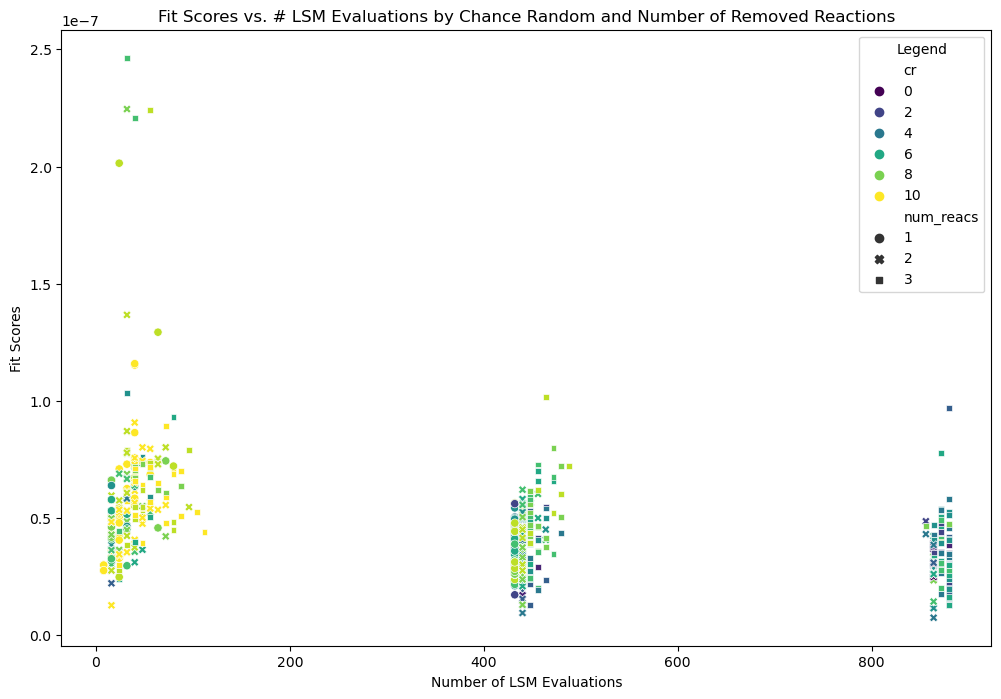

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data from both experiments
all_experiments = []

# Process seed42 results
for _, row in results_df_efm_seed42.iterrows():
    num_reacs = row['num_reacs']
    cr = row['cr']
    df = row['dataframe']
    df['num_reacs'] = num_reacs
    df['cr'] = cr
    df['experiment'] = 'seed42'  # Add experiment identifier
    all_experiments.append(df)

# Process seed17 results
for _, row in results_df_efm_seed17.iterrows():
    num_reacs = row['num_reacs']
    cr = row['cr']
    df = row['dataframe']
    df['num_reacs'] = num_reacs
    df['cr'] = cr
    df['experiment'] = 'seed17'  # Add experiment identifier
    all_experiments.append(df)

# Combine into a single DataFrame
combined_df = pd.concat(all_experiments)

# Scatter Plot: Scores vs. Computation Time by Chance Random and Experiment
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df,
    x='Number of LSQ Computations',
    y='Scores',
    hue='cr',  # Differentiate experiments by color
    style='num_reacs',  # Use different markers for num_reacs
    palette='viridis'
)
plt.title('Fit Scores vs. # LSM Evaluations by Chance Random and Number of Removed Reactions')
plt.xlabel('Number of LSM Evaluations')
plt.ylabel('Fit Scores')
plt.legend(title='Legend')
plt.savefig("scatter_scores_vs_time_Combined_Model_EV.png", dpi=300, bbox_inches='tight')
plt.show()




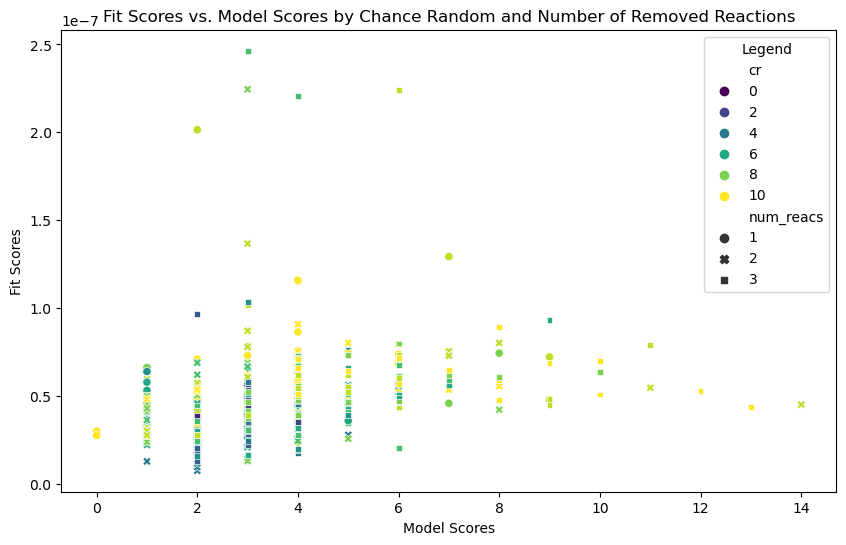

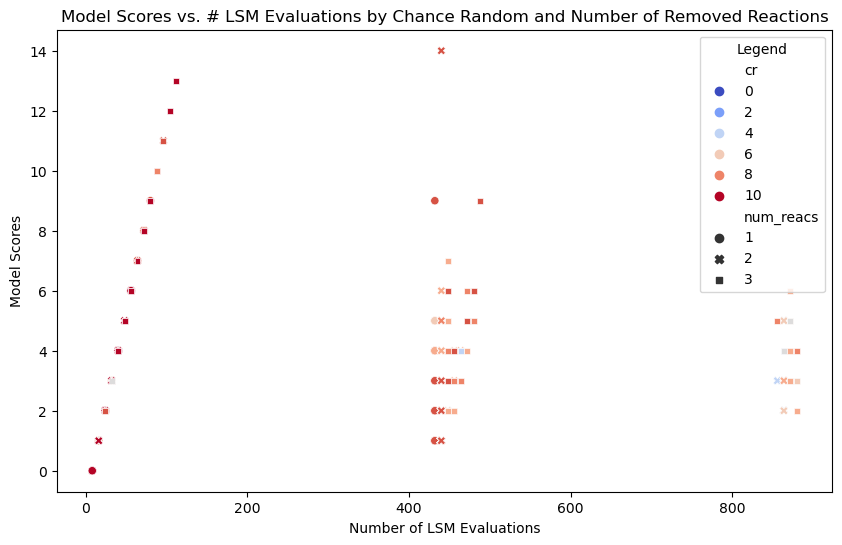

In [108]:
# Scatter Plot: Scores vs. Edit Distances by Temperature and Number of Reactions
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined_df,
    x='Edit Distances',
    y='Scores',
    hue='cr',
    style='num_reacs',
    palette='viridis'
)
plt.title('Fit Scores vs. Model Scores by Chance Random and Number of Removed Reactions')
plt.xlabel('Model Scores')
plt.ylabel('Fit Scores')
plt.legend(title='Legend')
plt.savefig("scatter_scores_vs_model_scores_EV.png", dpi=300, bbox_inches='tight')
plt.show()

# Scatter Plot: Edit Distances vs. Computation Times by Temperature and Number of Reactions
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined_df,
    x='Number of LSQ Computations',
    y='Edit Distances',
    hue='cr',
    style='num_reacs',
    palette='coolwarm'
)
plt.title('Model Scores vs. # LSM Evaluations by Chance Random and Number of Removed Reactions')
plt.xlabel('Number of LSM Evaluations')
plt.ylabel('Model Scores')
plt.legend(title='Legend')
plt.savefig("scatter_model_scores_vs_computation_time_EV.png", dpi=300, bbox_inches='tight')
plt.show()


In [103]:
# Combining the results from the experiments executed with different random seeds.
merged_evo_df_efm = pd.concat([results_df_efm_seed42, results_df_efm_seed17], ignore_index=True)

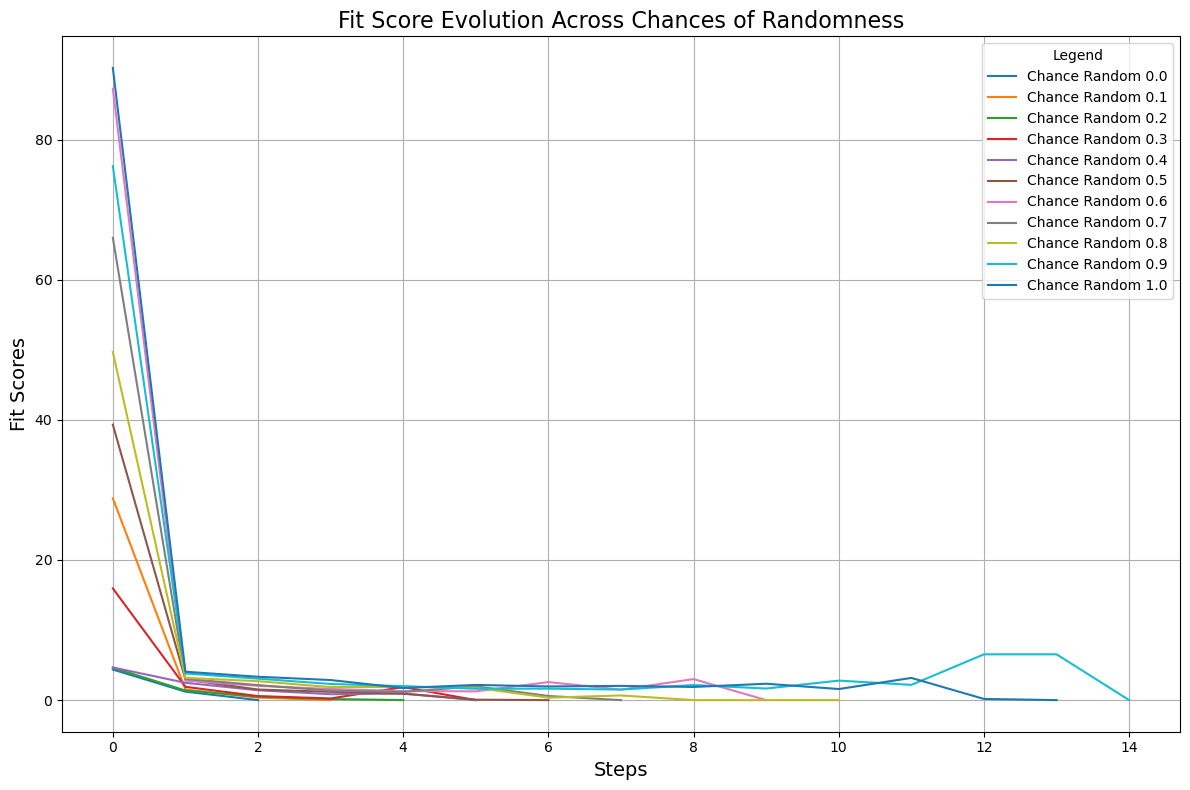

In [104]:
dataframes = merged_evo_df_efm
    
num_reacs_range = range(1,4)    
temp_range = range(0, 11)    
    
plt.figure(figsize=(12, 8))

for temp in temp_range:
    all_scores = []
    max_steps = 0

    for num_reacs in num_reacs_range:
        # Filter for the specific num_reacs and temp
        experiment_df = dataframes[(dataframes['num_reacs'] == num_reacs) & (dataframes['cr'] == temp)]

        if not experiment_df.empty:
            # Access the nested DataFrame for this combination
            for _, row in experiment_df.iterrows():
                nested_df = row['dataframe']  # Access the nested DataFrame
                if 'Score Evolutions' in nested_df.columns:
                    for scores in nested_df['Score Evolutions']:
                        max_steps = max(max_steps, len(scores))
                        all_scores.append(scores)

    # Compute mean scores at each step
    if all_scores:
        score_matrix = np.array(
            [np.pad(s, (0, max_steps - len(s)), constant_values=np.nan) for s in all_scores]
        )
        mean_scores = np.nanmean(score_matrix, axis=0)

        # Plot the mean scores for this temperature
        plt.plot(range(len(mean_scores)), mean_scores, label=f"Chance Random {temp/10}")

plt.xlabel("Steps", fontsize=14)
plt.ylabel("Fit Scores", fontsize=14)
plt.title("Fit Score Evolution Across Chances of Randomness", fontsize=16)
plt.legend(title="Legend", fontsize=10)
plt.grid(True)
plt.tight_layout()  # Sicherstellen, dass das Layout korrekt ist
plt.savefig("lines_scores_vs_steps_EV.png", dpi=300)  # Plot speichern
plt.show()  # Plot schließen    
